# Dreambooth 微调
## 预训练模型：stabilityai/stable-diffusion-3.5-medium

In [1]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

from huggingface_hub import notebook_login

notebook_login()

In [2]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from accelerate import Accelerator, notebook_launcher
import argparse

from diffusers import (
    StableDiffusion3Pipeline,     
    AutoencoderKL,                
    DDPMScheduler,
    FlowMatchEulerDiscreteScheduler                 
)
from diffusers import SD3Transformer2DModel
from transformers import CLIPTextModel, CLIPTokenizer,T5EncoderModel  
from datasets import load_dataset


In [3]:
dataset_id = "zjake/Memorial-Pavilion-of-TJU" #自己创建的数据集
# dataset_id = "zjake/Tupperware-blue-water-bottle"
dataset = load_dataset(dataset_id, split="train",cache_dir="./datasets")
dataset

Dataset({
    features: ['image'],
    num_rows: 10
})

In [4]:
def image_grid(imgs, rows, cols, size=256):
    assert len(imgs) == rows * cols
    resized_imgs = []
    for img in imgs:
        resized_imgs.append(img.resize((size, size), Image.LANCZOS))
    
    # 使用调整后的图片创建网格
    grid = Image.new("RGB", size=(cols * size, rows * size))
    for i, img in enumerate(resized_imgs):
        grid.paste(img, box=(i % cols * size, i // cols * size))
    return grid

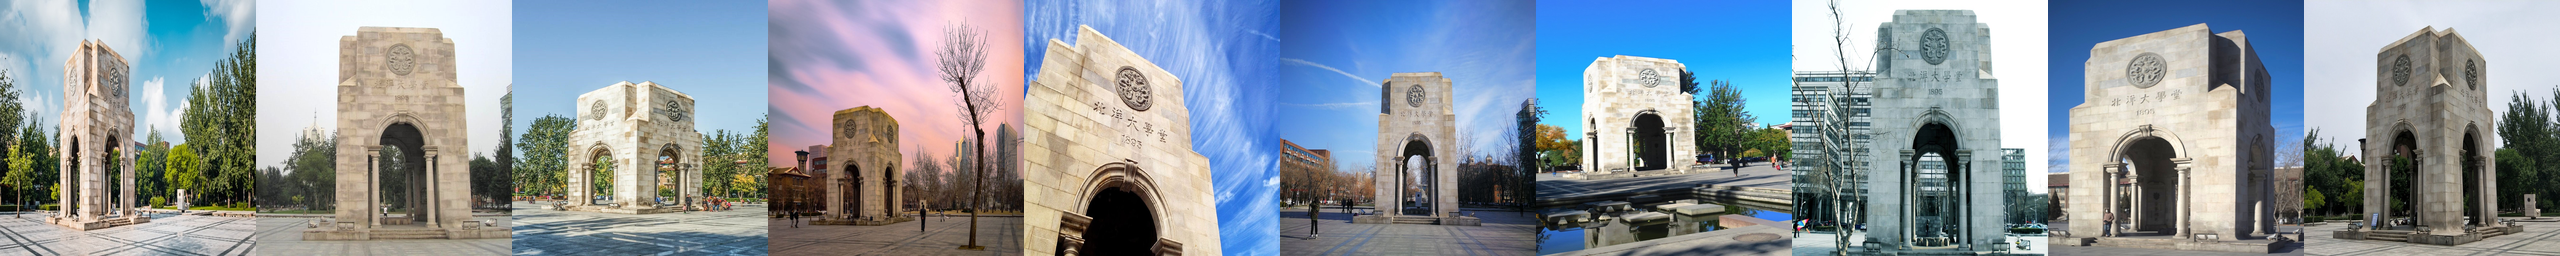

In [5]:
num_samples = 10
image_grid(dataset["image"][:num_samples], rows=1, cols=num_samples, size=256)

In [6]:
class DreamBoothDataset(torch.utils.data.Dataset):
    def __init__(self, instance_dir, class_dir, hf_ds, tokenizer, instance_prompt, class_prompt, size):
        self.tokenizer = tokenizer
        self.instance_prompt = instance_prompt
        self.class_prompt = class_prompt
        self.transform = transforms.Compose([
            transforms.Resize(size), transforms.CenterCrop(size),
            transforms.ToTensor(), transforms.Normalize([0.5],[0.5])
        ])
        
        # 实例图片
        if instance_dir:
            self.instance_images = [os.path.join(instance_dir, f) for f in os.listdir(instance_dir)
                           if f.lower().endswith(("jpg","png","jpeg"))]
            self.hf = None
        else:
            self.hf = hf_ds
            self.instance_images = None
        
        # 类别图片
        self.class_images = None
        if class_dir and os.path.exists(class_dir):
            self.class_images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                        if f.lower().endswith(("jpg","png","jpeg"))]
        
        self.num_instance_images = len(self.hf) if self.hf else len(self.instance_images)
        self.num_class_images = 0 if self.class_images is None else len(self.class_images)
        self._length = self.num_instance_images + self.num_class_images
        
    def __len__(self):
        return self._length
        
    def __getitem__(self, i):
        # 实例图片
        if i < self.num_instance_images:
            if self.hf:
                item = self.hf[i]
                img = item["image"] if isinstance(item["image"], Image.Image) \
                      else Image.open(item["image"]).convert("RGB")
                prompt = self.instance_prompt
            else:
                img = Image.open(self.instance_images[i]).convert("RGB")
                prompt = self.instance_prompt
        # 类别图片
        else:
            img_path = self.class_images[i - self.num_instance_images]
            img = Image.open(img_path).convert("RGB")
            prompt = self.class_prompt
            
        img = self.transform(img)
        tokens = self.tokenizer(
            prompt,
            padding="max_length", truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt"
        ).input_ids.squeeze()
        
        return {"pixel_values": img, "input_ids": tokens, "is_class": i >= self.num_instance_images}

In [7]:
import os
import torch
from transformers import T5EncoderModel, BitsAndBytesConfig
from accelerate import init_empty_weights, load_checkpoint_and_dispatch
import pickle

def optimize_t5_encoder(model_id="stabilityai/stable-diffusion-3.5-medium", optimization_level="all"):
    """
    优化T5-XXL文本编码器，减少显存占用
    
    参数:
        model_id: 模型ID
        optimization_level: 优化级别
            - "quantize_8bit": 使用8位量化
            - "quantize_4bit": 使用4位量化  
            - "cpu_offload": 使用CPU卸载
            - "precompute": 预计算并缓存文本嵌入
            - "all": 应用所有优化 (默认)
    
    返回:
        优化后的text_encoder_3
    """
    # 设置量化配置
    if "quantize" in optimization_level:
        if "4bit" in optimization_level:
            print("使用4位量化加载T5-XXL...")
            bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_use_double_quant=True
            )
        else:
            print("使用8位量化加载T5-XXL...")
            bnb_config = BitsAndBytesConfig(
                load_in_8bit=True
            )
        
        # 使用量化配置加载模型
        text_encoder_3 = T5EncoderModel.from_pretrained(
            model_id,
            subfolder="text_encoder_3",
            device_map="auto",  # 自动管理设备放置
            quantization_config=bnb_config,
            torch_dtype=torch.float16
        )
    
    # CPU卸载策略
    elif optimization_level == "cpu_offload":
        print("使用CPU卸载策略加载T5-XXL...")
        # 使用accelerate的empty weights初始化和加载
        with init_empty_weights():
            text_encoder_3 = T5EncoderModel.from_pretrained(
                model_id,
                subfolder="text_encoder_3",
                torch_dtype=torch.float16
            )
        
        # 加载并设置设备映射策略
        text_encoder_3 = load_checkpoint_and_dispatch(
            text_encoder_3, 
            model_id + "/text_encoder_3", 
            device_map="auto",
            offload_folder="offload_folder"
        )
    
    # 组合优化或默认
    else:
        print("应用默认量化 + 切片优化...")
        bnb_config = BitsAndBytesConfig(load_in_8bit=True)
        text_encoder_3 = T5EncoderModel.from_pretrained(
            model_id,
            subfolder="text_encoder_3",
            device_map="auto",
            quantization_config=bnb_config,
            torch_dtype=torch.float16
        )
    
    return text_encoder_3

class TextEmbeddingCache:
    """
    T5-XXL文本嵌入缓存类，用于预计算和重用文本嵌入
    """
    def __init__(self, pipe, cache_dir="./text_embeddings_cache"):
        self.pipe = pipe
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)
        self.cache = {}
    
    def get_embedding_path(self, prompt_key):
        """获取缓存文件路径"""
        import hashlib
        prompt_hash = hashlib.md5(prompt_key.encode()).hexdigest()
        return os.path.join(self.cache_dir, f"{prompt_hash}.pkl")
    
    def encode_and_cache(self, prompt_list, device="cuda"):
        """编码并缓存文本嵌入"""
        # 生成批次的唯一键
        batch_key = "||".join(prompt_list)
        
        # 检查缓存中是否已存在
        if batch_key in self.cache:
            print("从内存缓存中加载文本嵌入")
            return self.cache[batch_key]
        
        # 检查文件缓存
        cache_path = self.get_embedding_path(batch_key)
        if os.path.exists(cache_path):
            print(f"从文件缓存中加载文本嵌入: {cache_path}")
            with open(cache_path, "rb") as f:
                embeddings = pickle.load(f)
            self.cache[batch_key] = embeddings
            return embeddings
        
        # 不存在缓存，执行编码
        print("计算并缓存新的文本嵌入...")
        
        # 保存text_encoder_3原始设备位置
        if hasattr(self.pipe, 'text_encoder_3'):
            original_device = self.pipe.text_encoder_3.device
            self.pipe.text_encoder_3 = self.pipe.text_encoder_3.to("cpu")
        
        with torch.no_grad():
            prompt_embeds = self.pipe.encode_prompt(
                prompt_list,        # prompt 
                prompt_list,        # prompt_2
                prompt_list,        # prompt_3
                device=device,
                num_images_per_prompt=1,
                do_classifier_free_guidance=False
            )
        
        # 恢复text_encoder_3位置
        if hasattr(self.pipe, 'text_encoder_3'):
            self.pipe.text_encoder_3 = self.pipe.text_encoder_3.to(original_device)
        
        result = prompt_embeds
        
        # 保存到缓存
        self.cache[batch_key] = result
        
        # 保存到文件
        with open(cache_path, "wb") as f:
            pickle.dump(result, f)
        
        return result

def optimize_encode_prompt(pipe, prompt_list, device, cache_embeddings=False):
    """
    encode_prompt函数，适配SD3.5
    
    参数:
        pipe: SD3 pipeline
        prompt_list: 提示词列表
        device: 设备
        cache_embeddings: 是否缓存嵌入
    
    返回:
        编码结果
    """
    if cache_embeddings:
        # 使用缓存
        if not hasattr(pipe, '_embedding_cache'):
            pipe._embedding_cache = TextEmbeddingCache(pipe)
        
        return pipe._embedding_cache.encode_and_cache(prompt_list, device)
    else:
        # 不使用缓存，但仍优化内存使用
        with torch.no_grad():
            # 保存所有编码器的原始设备位置
            text_encoder_device = pipe.text_encoder.device if hasattr(pipe, 'text_encoder') else None
            text_encoder_2_device = pipe.text_encoder_2.device if hasattr(pipe, 'text_encoder_2') else None
            text_encoder_3_device = pipe.text_encoder_3.device if hasattr(pipe, 'text_encoder_3') else None
            
            # 临时将所有模型移至相同设备(CPU)以避免设备不匹配错误
            if hasattr(pipe, 'text_encoder'):
                pipe.text_encoder = pipe.text_encoder.to("cpu")
            if hasattr(pipe, 'text_encoder_2'):
                pipe.text_encoder_2 = pipe.text_encoder_2.to("cpu")
            if hasattr(pipe, 'text_encoder_3'):
                pipe.text_encoder_3 = pipe.text_encoder_3.to("cpu")
                
            # 确保prompt_list在CPU上处理
            prompt_embeds = pipe.encode_prompt(
                prompt_list,      # prompt (位置参数)
                prompt_list,      # prompt_2 (位置参数)
                prompt_list,      # prompt_3 (位置参数)
                device="cpu",     # 重要：先在CPU上处理，避免设备不匹配
                num_images_per_prompt=1,
                do_classifier_free_guidance=False
            )
            
            # 将结果转移到目标设备
            if isinstance(prompt_embeds, tuple):
                prompt_embeds = tuple(p.to(device) for p in prompt_embeds if p is not None)
            else:
                prompt_embeds = prompt_embeds.to(device)
            
            # 恢复原始设备位置
            if hasattr(pipe, 'text_encoder') and text_encoder_device is not None:
                pipe.text_encoder = pipe.text_encoder.to(text_encoder_device)
            if hasattr(pipe, 'text_encoder_2') and text_encoder_2_device is not None:
                pipe.text_encoder_2 = pipe.text_encoder_2.to(text_encoder_2_device)
            if hasattr(pipe, 'text_encoder_3') and text_encoder_3_device is not None:
                pipe.text_encoder_3 = pipe.text_encoder_3.to(text_encoder_3_device)
            
            return prompt_embeds
        
def training_encode_prompt(text_encoder, text_encoder_2, text_encoder_3, tokenizer, prompt_list, device):
    """
    训练专用的文本编码函数，支持梯度反向传播
    
    参数:
        text_encoder: CLIP文本编码器 1
        text_encoder_2: CLIP文本编码器 2
        text_encoder_3: T5-XXL文本编码器 3
        tokenizer: 分词器
        prompt_list: 提示词列表
        device: 目标设备
        
    返回:
        tuple: (prompt_embeds, pooled_prompt_embeds) 适用于SD3.5的格式
    """
    # 分词
    input_ids = tokenizer(
        prompt_list,
        padding="max_length",
        truncation=True,
        max_length=tokenizer.model_max_length,
        return_tensors="pt"
    ).input_ids.to(device)
    
    # 从第一个CLIP文本编码器获取隐藏状态
    clip_output_1 = text_encoder(input_ids, output_hidden_states=True)
    hidden_states_1 = clip_output_1.hidden_states[-2]
    pooled_output_1 = clip_output_1[0]  # 第一个CLIP的pooled输出
    
    # 从第二个CLIP文本编码器获取隐藏状态和池化输出
    clip_output_2 = text_encoder_2(input_ids, output_hidden_states=True)
    hidden_states_2 = clip_output_2.hidden_states[-2]
    pooled_output_2 = clip_output_2[0]  # 第二个CLIP的pooled输出
    
    # 合并两个CLIP模型的池化输出
    # SD3.5 通过拼接两个pooled_outputs获得2048维向量
    pooled_output = torch.cat([pooled_output_1, pooled_output_2], dim=-1)
    
    # 4. 合并CLIP隐藏状态
    clip_hidden_states = torch.cat([hidden_states_1, hidden_states_2], dim=-1)
    
    # T5编码器处理
    if text_encoder_3 is not None:
        try:
            # 加载T5分词器
            from transformers import T5TokenizerFast
            t5_tokenizer = T5TokenizerFast.from_pretrained(
                "stabilityai/stable-diffusion-3.5-medium", 
                subfolder="tokenizer_3"
            )
            
            # 不需要梯度的T5处理
            with torch.no_grad():
                # 确保在正确设备上操作
                t5_device = next(text_encoder_3.parameters()).device

                t5_inputs = t5_tokenizer(
                    prompt_list,
                    padding="max_length",
                    max_length=226,
                    truncation=True,
                    return_tensors="pt"
                )
                t5_input_ids = t5_inputs.input_ids.to(t5_device)
                t5_embeds = text_encoder_3(t5_input_ids)[0]
                
                # 将结果移回主设备
                if t5_device != device:
                    t5_embeds = t5_embeds.to(device)
            
            # 填充和合并
            clip_hidden_states = torch.nn.functional.pad(
                clip_hidden_states, (0, t5_embeds.shape[-1] - clip_hidden_states.shape[-1])
            )
            prompt_embeds = torch.cat([clip_hidden_states, t5_embeds], dim=-2)
            
        except Exception as e:
            print(f"T5 编码过程出错，仅使用 CLIP 编码: {str(e)}")
            prompt_embeds = clip_hidden_states
    else:
        prompt_embeds = clip_hidden_states
    
    return prompt_embeds, pooled_output

In [8]:
import os, torch, gc
from torch import autocast
# Diffusers 与 Transformers
from diffusers import DiffusionPipeline, StableDiffusion3Pipeline, BitsAndBytesConfig, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer, T5TokenizerFast
from peft import LoraConfig, get_peft_model

device = "cuda" if torch.cuda.is_available() else "cpu"
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128,garbage_collection_threshold:0.6,expandable_segments:True,roundup_power2_divisions:2"

pipe = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3.5-medium",
    torch_dtype=torch.bfloat16,
    # text_encoder_3=None,             
    resume_download=True,
    cache_dir="./models/huggingface"
).to(device)

# print("已加载模型")
# 开启显存优化
try:
    pipe.enable_xformers_memory_efficient_attention()
    print("已启用 xFormers 高效注意力。")
except Exception:
    print("未检测到 xFormers，可跳过或切换到 PyTorch 2.0。")

pipe.enable_attention_slicing()
print("已启用注意力切片。")

Keyword arguments {'resume_download': True} are not expected by StableDiffusion3Pipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


未检测到 xFormers，可跳过或切换到 PyTorch 2.0。
已启用注意力切片。


```
model_id = "stabilityai/stable-diffusion-3.5-medium"`
tokenizer   = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder   = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
text_encoder_2 = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder_2")
text_encoder_3 = T5EncoderModel.from_pretrained(model_id, subfolder="text_encoder_3")   # T5-XXL
vae         = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
transformer = SD3Transformer2DModel.from_pretrained(model_id, subfolder="transformer")
scheduler   = FlowMatchEulerDiscreteScheduler.from_pretrained(
    model_id, subfolder="scheduler"
)
```

In [9]:
# model_id                = "stabilityai/stable-diffusion-3.5-medium"
instance_dir            = None
hf_dataset_id = "zjake/Memorial-Pavilion-of-TJU"
# hf_dataset_id           = "zjake/Tupperware-blue-water-bottle"
hf_split                = "train"

name_of_your_concept   = "bydxt"
type_of_thing          = "Pavilion"
instance_prompt         = f"a photo of {name_of_your_concept} {type_of_thing}"
#"a photo of {name_of_your_concept} {type_of_thing}"
resolution              = 512
train_batch_size        = 2
gradient_accumulation   = 1
learning_rate           = 4e-6
num_train_steps         = 2000
seed                    = 343
output_dir              = "./dreambooth-sd35"
gradient_checkpointing  = True

# 先验保存相关配置
with_prior_preservation = True         # 是否使用先验保存
prior_loss_weight = 1.0                # 先验保存损失的权重
class_prompt = "a photo of a Pavilion"   # 类别提示词（不含特殊标识符）
num_class_images = 100                  # 生成的类别图片数量
class_data_dir = f"{output_dir}/class_images/{name_of_your_concept}"  # 类别图片保存路径

```
prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k" #官方给予的提示词
image = pipe(prompt).images[0]
display(image)
image.save("test_output.png")

In [10]:
model_id = "stabilityai/stable-diffusion-3.5-medium"

transformer = pipe.transformer
vae = pipe.vae
flow_scheduler = pipe.scheduler

# 获取所有tokenizer
tokenizer = pipe.tokenizer           # CLIP 路径 1
tokenizer_2 = pipe.tokenizer_2       # CLIP 路径 2
tokenizer_3 = T5TokenizerFast.from_pretrained(
    model_id,
    subfolder="tokenizer_3",
    cache_dir="./models/huggingface"
)

# 添加自定义概念前的词汇表大小
orig_len_1 = len(tokenizer)
orig_len_2 = len(tokenizer_2)
orig_len_3 = len(tokenizer_3)

# 可以添加多个概念
concepts = [name_of_your_concept]
print(f"添加概念: {concepts}")

# 添加概念token到所有tokenizer
for tok in (tokenizer, tokenizer_2):
    num_added = tok.add_tokens(concepts)
    print(f"添加到tokenizer: {num_added} tokens")

# T5 tokenizer需要特殊处理
special_tokens_dict = {'additional_special_tokens': concepts}
num_added_t5 = tokenizer_3.add_special_tokens(special_tokens_dict)
print(f"添加到T5 tokenizer: {num_added_t5} tokens")

# 确认token已添加并获取ID
instance_id = tokenizer.convert_tokens_to_ids(name_of_your_concept)
instance_id_2 = tokenizer_2.convert_tokens_to_ids(name_of_your_concept)
instance_id_3 = tokenizer_3.convert_tokens_to_ids(name_of_your_concept)

type_id = tokenizer.convert_tokens_to_ids(type_of_thing)
type_id_2 = tokenizer_2.convert_tokens_to_ids(type_of_thing)
type_id_3 = tokenizer_3.convert_tokens_to_ids(type_of_thing)

print(f"概念ID: CLIP1={instance_id}, CLIP2={instance_id_2}, T5={instance_id_3}")
print(f"类型ID: CLIP1={type_id}, CLIP2={type_id_2}, T5={type_id_3}")

# 检查token是否成功添加
if instance_id == tokenizer.unk_token_id or instance_id_2 == tokenizer_2.unk_token_id:
    print("警告：概念token未能正确添加到CLIP tokenizer")

# 扩展和初始化CLIP编码器嵌入
for enc, inst_id, t_id, tok, name in (
    (pipe.text_encoder, instance_id, type_id, tokenizer, "CLIP-1"),
    (pipe.text_encoder_2, instance_id_2, type_id_2, tokenizer_2, "CLIP-2"),
):
    # 检查是否需要扩展
    if len(tok) > enc.get_input_embeddings().weight.shape[0]:
        print(f"调整{name}嵌入大小：{enc.get_input_embeddings().weight.shape[0]} → {len(tok)}")
        enc.resize_token_embeddings(len(tok))
        
    # 使用更智能的初始化：类型嵌入 + 随机小噪声以打破对称性
    with torch.no_grad():
        # 获取类型嵌入
        type_embedding = enc.get_input_embeddings().weight[t_id].clone()
        
        # 添加少量随机噪声以帮助模型区分新概念
        noise_scale = 0.1  # 噪声比例，可调整
        noise = torch.randn_like(type_embedding) * noise_scale * type_embedding.std()
        
        # 设置初始嵌入为类型嵌入+噪声
        enc.get_input_embeddings().weight[inst_id] = type_embedding + noise
        
        print(f"已初始化{name}嵌入，使用类型'{type_of_thing}'作为基础")

# 扩展和初始化T5编码器嵌入
text_encoder_3 = pipe.text_encoder_3
if len(tokenizer_3) > text_encoder_3.shared.weight.shape[0]:
    print(f"调整T5嵌入大小：{text_encoder_3.shared.weight.shape[0]} → {len(tokenizer_3)}")
    
    # T5处理方式不同，需要同时调整多个嵌入矩阵
    # 保存原始权重
    old_embeds = text_encoder_3.shared.weight.data.clone()
    
    # 调整嵌入大小
    text_encoder_3.resize_token_embeddings(len(tokenizer_3))
    
    # 恢复原始权重
    with torch.no_grad():
        text_encoder_3.shared.weight[:old_embeds.shape[0], :] = old_embeds
    
    # 智能初始化新token嵌入
    with torch.no_grad():
        # T5使用shared权重，所以只需要设置一次
        # 获取类型嵌入并添加少量噪声
        if type_id_3 < old_embeds.shape[0]:  # 检查类型ID是否有效
            type_embedding = text_encoder_3.shared.weight[type_id_3].clone()
            noise_scale = 0.05  # T5通常使用较小噪声
            noise = torch.randn_like(type_embedding) * noise_scale * type_embedding.std()
            text_encoder_3.shared.weight[instance_id_3] = type_embedding + noise
            print(f"已初始化T5嵌入，使用类型'{type_of_thing}'作为基础")
        else:
            # 如果没有合适的类型嵌入，使用相似词的平均嵌入
            similar_tokens = ["object", "item", "thing", type_of_thing.split()[0]]
            similar_ids = [tokenizer_3.convert_tokens_to_ids(t) for t in similar_tokens]
            valid_ids = [i for i in similar_ids if i < old_embeds.shape[0]]
            
            if valid_ids:
                avg_embedding = text_encoder_3.shared.weight[valid_ids].mean(dim=0)
                text_encoder_3.shared.weight[instance_id_3] = avg_embedding
                print(f"已初始化T5嵌入，使用相似词的平均嵌入")
            else:
                print("警告：无法为T5找到合适的初始化嵌入")

# 将更新后的tokenizer设置回pipeline
pipe.tokenizer = tokenizer
pipe.tokenizer_2 = tokenizer_2
pipe.tokenizer_3 = tokenizer_3

# 将更新后的文本编码器设置回pipeline
text_encoder = pipe.text_encoder
text_encoder_2 = pipe.text_encoder_2
text_encoder_3 = pipe.text_encoder_3

print(f"完成！已添加概念'{name_of_your_concept}'到全部三个文本编码器")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


添加概念: ['bydxt']
添加到tokenizer: 1 tokens
添加到tokenizer: 1 tokens
添加到T5 tokenizer: 1 tokens
概念ID: CLIP1=49408, CLIP2=49408, T5=32100
类型ID: CLIP1=49407, CLIP2=49407, T5=2
调整CLIP-1嵌入大小：49408 → 49409
已初始化CLIP-1嵌入，使用类型'Pavilion'作为基础
调整CLIP-2嵌入大小：49408 → 49409
已初始化CLIP-2嵌入，使用类型'Pavilion'作为基础
完成！已添加概念'bydxt'到全部三个文本编码器


In [11]:
from diffusers import StableDiffusion3Pipeline
import os, tqdm
from pathlib import Path

def generate_class_images(
    class_prompt,
    class_data_dir,
    num_class_images,
    device,
    guidance_scale=4,
    num_inference_steps=40,
    pipe=pipe
):
    """生成类别图片"""
    os.makedirs(class_data_dir, exist_ok=True)
    
    # 检查目录中图片数量，如果已足够则跳过
    class_images_available = len(list(Path(class_data_dir).iterdir()))
    if class_images_available >= num_class_images:
        print(f"已找到 {class_images_available} 张类别图片，跳过生成")
        return
    
    # 创建临时pipeline用于生成类别图片
    print(f"开始生成 {num_class_images} 张类别图片...")
    gen_pipe = pipe
    gen_pipe.to(device)
    gen_pipe.enable_attention_slicing()
    
    # 批量生成
    num_existing = len(os.listdir(class_data_dir))
    batch_size = 1  # 每次生成4张 
    
    with torch.no_grad():
        for i in tqdm.tqdm(range(0, num_class_images - num_existing, batch_size)):
            # 确定本批次实际生成数量
            current_batch_size = min(batch_size, num_class_images - num_existing - i)
            
            # 生成图片
            images = gen_pipe(
                prompt=[class_prompt] * current_batch_size,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                generator=torch.Generator(device=device).manual_seed(i + seed)
            ).images
            
            # 保存图片
            for j, img in enumerate(images):
                img_index = num_existing + i + j
                img.save(os.path.join(class_data_dir, f"class_image_{img_index:05d}.jpg"))
    
    print(f"类别图片生成完成，共 {len(os.listdir(class_data_dir))} 张")
    del gen_pipe
    gc.collect()
    torch.cuda.empty_cache()

In [12]:
#前向扩散工具函数
def get_sigmas(timesteps, scheduler, n_dim=4, dtype=torch.float32):
    sigmas = scheduler.sigmas.to(device=timesteps.device, dtype=dtype)
    steps = scheduler.timesteps.to(device=timesteps.device)
    idx = [(steps==t).nonzero().item() for t in timesteps]
    sigma = sigmas[idx].view(-1, *([1]* (n_dim-1)))
    return sigma

In [13]:
def collate_fn(examples):
    pixel_values = torch.stack([e["pixel_values"] for e in examples]).float().to(torch.bfloat16)
    input_ids = [e["input_ids"] for e in examples]
    input_ids = tokenizer.pad({"input_ids": input_ids},
                              padding=True, return_tensors="pt").input_ids
    
    # 标记哪些是类别图片
    is_class = torch.tensor([e["is_class"] for e in examples], dtype=torch.bool)
    
    return {"pixel_values": pixel_values, "input_ids": input_ids, "is_class": is_class}

In [14]:
import bitsandbytes as bnb
from accelerate.utils import set_seed
from peft import get_peft_model_state_dict
from diffusers import get_scheduler

set_seed(seed)
train_text_encoder = True       # 是否训练CLIP文本编码器
train_text_encoder_2 = True     # 是否训练第二个CLIP文本编码器

accelerator = Accelerator(
    gradient_accumulation_steps=gradient_accumulation,
    mixed_precision="bf16",   #['no', 'fp8', 'fp16', 'bf16']
)
if gradient_checkpointing:
    transformer.enable_gradient_checkpointing()
    if train_text_encoder:
        text_encoder.gradient_checkpointing_enable()
    if train_text_encoder_2:
        text_encoder_2.gradient_checkpointing_enable()

# 在训练开始前生成类别图片
if with_prior_preservation:
    generate_class_images(
        class_prompt=class_prompt,
        class_data_dir=class_data_dir,
        num_class_images=num_class_images,
        device=accelerator.device,
        pipe=pipe
    )

# 数据加载
if hf_dataset_id:
    hf_ds = load_dataset(hf_dataset_id, split=hf_split)
else:
    hf_ds = None
    
train_ds = DreamBoothDataset(
    instance_dir=instance_dir, 
    class_dir=class_data_dir if with_prior_preservation else None,
    hf_ds=hf_ds, 
    tokenizer=tokenizer, 
    instance_prompt=instance_prompt,
    class_prompt=class_prompt,
    size=resolution
)
train_dl = DataLoader(
    train_ds, 
    batch_size=train_batch_size,
    shuffle=True, 
    collate_fn=collate_fn, 
    num_workers=0, 
    pin_memory=False
)
# 优化器
params_to_optimize = []

# 添加transformer参数
params_to_optimize.append(
    {"params": transformer.parameters(), "lr": learning_rate}
)

# 添加文本编码器参数
if train_text_encoder:
    params_to_optimize.append(
        {"params": text_encoder.parameters(), "lr": learning_rate * 0.5}  # 文本编码器使用较小的学习率
    )
if train_text_encoder_2:
    params_to_optimize.append(
        {"params": text_encoder_2.parameters(), "lr": learning_rate * 0.5}
    )

# optimizer = bnb.optim.Adam8bit(params_to_optimize)
optimizer = torch.optim.AdamW(params_to_optimize)
lr_scheduler = get_scheduler(
    name="constant",                   # 或"cosine"
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_train_steps
)

vae.to(accelerator.device, dtype=torch.bfloat16)
# Accelerator 包装
text_encoder, text_encoder_2, transformer, optimizer, lr_scheduler, train_dl = accelerator.prepare(
    text_encoder, text_encoder_2, transformer, optimizer, lr_scheduler, train_dl
)

# 训练前初始化：完全冻结文本编码器参数
def freeze_text_encoders(text_encoder, text_encoder_2):
    for param in text_encoder.parameters():
        param.requires_grad = False
    for param in text_encoder_2.parameters():
        param.requires_grad = False
    
# 解冻文本编码器参数函数
def unfreeze_text_encoders(text_encoder, text_encoder_2):
    for param in text_encoder.parameters():
        param.requires_grad = True
    for param in text_encoder_2.parameters():
        param.requires_grad = True

if train_text_encoder:
    text_encoder.train()
else:
    text_encoder.eval()
    # 仅在不训练时冻结
    for param in text_encoder.parameters():
        param.requires_grad = False

if train_text_encoder_2:
    text_encoder_2.train()
else:
    text_encoder_2.eval()
    # 仅在不训练时冻结
    for param in text_encoder_2.parameters():
        param.requires_grad = False
print("完成")

已找到 100 张类别图片，跳过生成
完成


In [15]:
import torch
import gc
# 运行垃圾回收
# gc.collect()
# 清空CUDA缓存
# torch.cuda.empty_cache()
print(f"当前分配的GPU内存: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"峰值保留: {torch.cuda.max_memory_reserved() / 1e9:.2f} GB")

当前分配的GPU内存: 16.32 GB
峰值保留: 17.56 GB


### Dreambooth训练

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

预计算VAE编码...


缓存VAE编码:   0%|          | 0/55 [00:00<?, ?it/s]

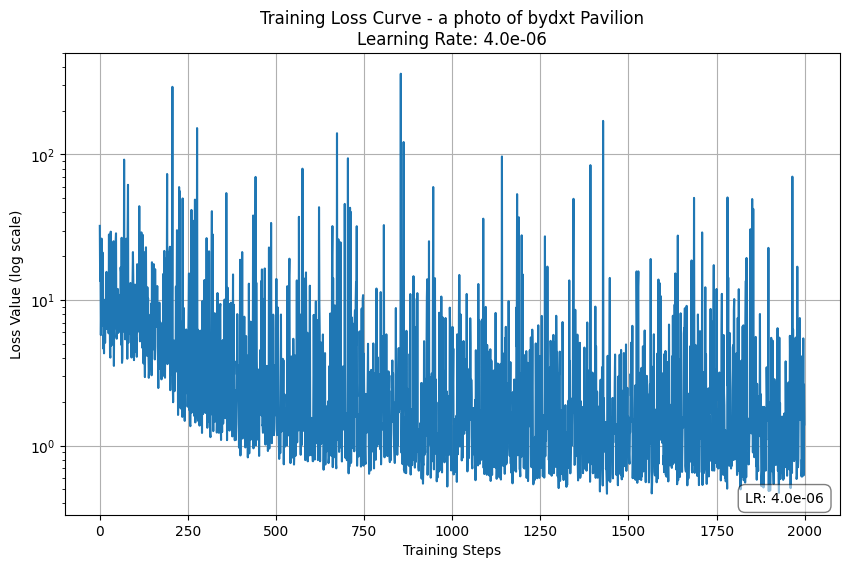

损失曲线已保存至: ./dreambooth-sd35/loss_curves/loss_curve_lr_bydxt_4.0em06_2000steps.png
保存检查点到 ./dreambooth-sd35/text_checkpoint-bydxt_4.0e-06_2000steps


In [16]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from diffusers.training_utils import (
    compute_density_for_timestep_sampling,
    compute_loss_weighting_for_sd3
)
# 训练前初始化，存储训练损失
loss_history = []
global_step = 0
transformer.train()

progress_bar = tqdm(total=num_train_steps, desc="Training", disable=not accelerator.is_local_main_process)

# 训练前预计算
latents_cache = []
class_mask = []
print("预计算VAE编码...")
vae.to(accelerator.device)  # 保持VAE在GPU上
for batch in tqdm(train_dl, desc="缓存VAE编码"):
    with torch.no_grad():
        pixel_values = batch["pixel_values"].to(accelerator.device, dtype=torch.bfloat16)
        latent = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor
        batch_size = latent.shape[0]
        
        # 存储潜空间编码
        latents_cache.append(latent.cpu())  
        
        # 确保class_mask有相同数量的元素
        if with_prior_preservation:
            if "is_class" in batch and batch["is_class"].shape[0] == batch_size:
                class_mask.append(batch["is_class"].cpu())
            else:
                class_mask.append(torch.zeros(batch_size, dtype=torch.bool))

# 构建新数据集
from torch.utils.data import TensorDataset, DataLoader
# 构建新数据集时检查长度
if with_prior_preservation:
    # 验证形状匹配
    all_latents = torch.cat(latents_cache)
    all_masks = torch.cat(class_mask)
    
    if all_latents.shape[0] != all_masks.shape[0]:
        print(f"警告: 潜空间形状 {all_latents.shape[0]} 与类掩码形状 {all_masks.shape[0]} 不匹配")
        # 填充缺失的掩码 (如果latents更多)
        if all_latents.shape[0] > all_masks.shape[0]:
            padding = torch.zeros(all_latents.shape[0] - all_masks.shape[0], dtype=torch.bool)
            all_masks = torch.cat([all_masks, padding])
        # 截断掩码 (如果掩码更多)
        else:
            all_masks = all_masks[:all_latents.shape[0]]
        
    latents_dataset = TensorDataset(all_latents, all_masks)
else:
    latents_dataset = TensorDataset(torch.cat(latents_cache))
    
cached_dataloader = DataLoader(latents_dataset, batch_size=train_batch_size, shuffle=True)

prompts_instance = [instance_prompt] * train_batch_size
prompts_class = [class_prompt] * num_class_images if with_prior_preservation else None
# 传入三路文本编码器, 不训练文本编码器时使用
# 分别准备实例提示词和类别提示词的嵌入
instance_prompt_embeds, _, instance_pooled_embeds, _ = pipe.encode_prompt(
    prompts_instance, prompts_instance, prompts_instance,
    do_classifier_free_guidance=False,
    num_images_per_prompt=1
)
instance_prompt_embeds = instance_prompt_embeds.detach()
instance_pooled_embeds = instance_pooled_embeds.detach()

# 处理类别提示词嵌入 - 采用分批处理
if with_prior_preservation:
    batch_size = 1  # 每批处理1个提示词
    
    # 初始化存储
    all_class_prompt_embeds = []
    all_class_pooled_embeds = []
    
    # 分批处理类别提示词
    for i in range(0, len(prompts_class), batch_size):
        # 清理GPU内存
        gc.collect()
        torch.cuda.empty_cache()
        
        # 获取当前批次的提示词
        batch_prompts = prompts_class[i:i+batch_size]
        
        # 为当前批次生成嵌入
        # print(f"处理类别提示词批次 {i//batch_size + 1}/{(len(prompts_class)-1)//batch_size + 1}")
        
        try:
            with torch.inference_mode():
                batch_embeds, _, batch_pooled, _ = pipe.encode_prompt(
                    batch_prompts, batch_prompts, batch_prompts,
                    do_classifier_free_guidance=False,
                    num_images_per_prompt=1
                )
                
            # 收集结果 - 立即转移到CPU以减少GPU内存占用
            all_class_prompt_embeds.append(batch_embeds.cpu())
            all_class_pooled_embeds.append(batch_pooled.cpu())
        
        except Exception as e:
            print(f"处理批次 {i//batch_size + 1} 时出错: {e}")
            # 继续处理下一批
            continue
    
    # 合并所有批次结果
    torch.cuda.empty_cache()
    
    if all_class_prompt_embeds:
        class_prompt_embeds = torch.cat(all_class_prompt_embeds, dim=0)
        class_pooled_embeds = torch.cat(all_class_pooled_embeds, dim=0)
        
        # 只保留所需数量的嵌入，并转移到GPU
        needed_count = min(train_batch_size, class_prompt_embeds.shape[0])
        class_prompt_embeds = class_prompt_embeds[:needed_count].to(accelerator.device)
        class_pooled_embeds = class_pooled_embeds[:needed_count].to(accelerator.device)

        class_prompt_embeds = class_prompt_embeds.detach()
        class_pooled_embeds = class_pooled_embeds.detach()
    else:
        print("警告：无法生成任何类别提示词嵌入，使用实例嵌入代替")
        class_prompt_embeds = instance_prompt_embeds.clone()
        class_pooled_embeds = instance_pooled_embeds.clone()

for param in vae.parameters(): param.requires_grad = False

num_epochs = (num_train_steps * gradient_accumulation) // len(cached_dataloader) + 1

for epoch in range(num_epochs):
    for batch_idx, batch in enumerate(cached_dataloader):
        with accelerator.accumulate(transformer):
            
            latents = batch[0].to(accelerator.device)
            is_class = batch[1].to(accelerator.device) if with_prior_preservation else None
            bsz = latents.shape[0]
            # 每100步临时解冻文本编码器
            text_encoders_unfrozen = False
            if global_step > 0 and train_text_encoder:
                # 解冻文本编码器
                unfreeze_text_encoders(text_encoder, text_encoder_2)
                # text_encoders_unfrozen = True
                
                # 准备当前批次的提示词
                if with_prior_preservation and is_class is not None:
                    # 根据批次中的样本类型准备提示词列表
                    batch_prompts = []
                    for is_cls in is_class:
                        if is_cls:
                            batch_prompts.append(class_prompt)
                        else:
                            batch_prompts.append(instance_prompt)
                else:
                    batch_prompts = [instance_prompt] * bsz
                
                # 使用支持梯度的训练编码函数获取文本嵌入
                batch_prompt_embeds, batch_pooled_embeds = training_encode_prompt(
                    text_encoder=text_encoder,
                    text_encoder_2=text_encoder_2,
                    text_encoder_3=text_encoder_3,
                    tokenizer=tokenizer,
                    prompt_list=batch_prompts,
                    device=accelerator.device
                )

            # 流匹配前向扩散
            noise = torch.randn_like(latents)
            u = compute_density_for_timestep_sampling(
                weighting_scheme="logit_normal",
                batch_size=bsz,
                logit_mean=0.0,     # SD3-paper 中的 mu, sigma，可用 None 触发默认
                logit_std=1.0,
                mode_scale=None
            ).to(latents.device)
            timesteps_tensor = flow_scheduler.timesteps.to(latents.device)
            idx = (u * (flow_scheduler.config.num_train_timesteps - 1)).long().to(latents.device)
            timesteps = timesteps_tensor[idx]
            # 取出 σ_t
            sigmas = flow_scheduler.sigmas.to(latents.device)[idx].view(bsz, *([1] * (latents.ndim - 1)))
            noisy_latents = (1 - sigmas) * latents + sigmas * noise

            if with_prior_preservation and is_class is not None:
                # 准备批次的文本嵌入
                is_class_cpu = is_class.cpu()
                
                # 批次类型判断
                if is_class_cpu.all().item():  # 全是类别样本
                    batch_prompt_embeds = class_prompt_embeds.clone()
                    batch_pooled_embeds = class_pooled_embeds.clone()
                elif (~is_class_cpu).all().item():  # 全是实例样本  
                    batch_prompt_embeds = instance_prompt_embeds.clone()
                    batch_pooled_embeds = instance_pooled_embeds.clone()
                else:  # 混合批次
                    # 确保我们只使用第一个嵌入作为模板
                    instance_template = instance_prompt_embeds[0:1]  # [1, seq_len, dim]
                    class_template = class_prompt_embeds[0:1]        # [1, seq_len, dim]
                    instance_pooled_template = instance_pooled_embeds[0:1] 
                    class_pooled_template = class_pooled_embeds[0:1]
                    
                    # 初始化批次嵌入
                    batch_prompt_embeds = torch.zeros(
                        (bsz,) + instance_prompt_embeds.shape[1:], 
                        device=accelerator.device,
                        dtype=instance_prompt_embeds.dtype
                    )
                    batch_pooled_embeds = torch.zeros(
                        (bsz,) + instance_pooled_embeds.shape[1:],
                        device=accelerator.device, 
                        dtype=instance_pooled_embeds.dtype
                    )
                    
                    # 逐个位置填充
                    for i in range(bsz):
                        if is_class[i]:
                            batch_prompt_embeds[i] = class_template[0]
                            batch_pooled_embeds[i] = class_pooled_template[0]
                        else:
                            batch_prompt_embeds[i] = instance_template[0]
                            batch_pooled_embeds[i] = instance_pooled_template[0]
            else:
                # 不使用先验保存，全部使用实例嵌入
                batch_prompt_embeds = instance_prompt_embeds
                batch_pooled_embeds = instance_pooled_embeds
                
            if batch_pooled_embeds.shape[0] != bsz:
                if batch_pooled_embeds.shape[0] == 1:
                    batch_pooled_embeds = batch_pooled_embeds.expand(bsz, -1)
                else:
                    batch_pooled_embeds = batch_pooled_embeds[:bsz]
            
            if batch_prompt_embeds.shape[0] != bsz:
                if batch_prompt_embeds.shape[0] == 1:
                    batch_prompt_embeds = batch_prompt_embeds.expand(bsz, -1, -1)
                else:
                    batch_prompt_embeds = batch_prompt_embeds[:bsz]
            
            if isinstance(timesteps, torch.Tensor) and len(timesteps.shape) > 0:
                if timesteps.shape[0] != bsz:
                    first_timestep = timesteps[0].item()
                    timesteps = torch.full((bsz,), first_timestep, 
                                          device=timesteps.device, 
                                          dtype=timesteps.dtype)
            
            model_pred = transformer(
                hidden_states=noisy_latents,
                timestep=timesteps,
                encoder_hidden_states=batch_prompt_embeds,
                pooled_projections=batch_pooled_embeds,
                return_dict=False,
            )[0]
        
            # 预条件化
            model_pred = model_pred * (-sigmas) + noisy_latents
            # 计算损失
            loss_weights = compute_loss_weighting_for_sd3(
                weighting_scheme="sigma_sqrt",  # 或 "cosmap" / "none"
                sigmas=sigmas
            ).view(bsz, *([1] * (latents.ndim - 1)))

            if with_prior_preservation and is_class is not None:
                # 检查批次中是否既有实例图像也有类别图像
                has_instance = torch.any(~is_class).item()
                has_class = torch.any(is_class).item()
                
                if has_instance and has_class:
                    # 同时包含实例图像和类别图像的情况
                    # 分离实例数据和类别数据的预测
                    instance_pred = model_pred[~is_class]
                    class_pred = model_pred[is_class]
                    
                    # 分离实例数据和类别数据的目标
                    instance_target = (-latents)[~is_class]
                    class_target = (-latents)[is_class]
                    
                    # 分离损失权重
                    instance_weights = loss_weights[~is_class]
                    class_weights = loss_weights[is_class]
                    
                    # 计算实例损失
                    instance_loss = F.mse_loss(instance_pred.float(), instance_target.float(), reduction="none")
                    instance_loss = (instance_loss * instance_weights).mean()
                    
                    # 计算先验保存损失
                    prior_loss = F.mse_loss(class_pred.float(), class_target.float(), reduction="none")
                    prior_loss = (prior_loss * class_weights).mean()
                    
                    # 组合损失
                    loss = instance_loss + prior_loss_weight * prior_loss
                    
                    instance_loss_value = instance_loss.item()
                    prior_loss_value = prior_loss.item()
                else:
                    # 批次中只有一种类型的图像，使用常规损失计算
                    # print(f"批次中只包含{'类别' if has_class else '实例'}图像，使用常规损失计算")
                    loss = F.mse_loss(model_pred.float(), (-latents).float(), reduction="none")
                    loss = (loss * loss_weights).mean()
                    
                    # 记录损失值
                    if has_class:
                        instance_loss_value = 0.0
                        prior_loss_value = loss.item()
                    else:
                        instance_loss_value = loss.item()
                        prior_loss_value = 0.0
            else:
                # 普通损失计算（无先验保存）
                loss = F.mse_loss(model_pred.float(), (-latents).float(), reduction="none")
                loss = (loss * loss_weights).mean()
                instance_loss_value = None
                prior_loss_value = None

            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # # 反向传播后，再次冻结文本编码器参数
            # if text_encoders_unfrozen:
            #     freeze_text_encoders(text_encoder, text_encoder_2)
            #     prompt_embeds = prompt_embeds.detach()
            #     pooled_prompt_embeds = pooled_prompt_embeds.detach() 
            
        current_loss = loss.detach().item()

        if global_step>500 and global_step % 200 == 0 and global_step<1700 and accelerator.is_main_process:
            save_path = os.path.join(output_dir, f"text_checkpoint-{name_of_your_concept}_{learning_rate:.1e}_{global_step}steps")
            os.makedirs(save_path, exist_ok=True)
            accelerator.save_state(save_path)
            tokenizer.save_pretrained(os.path.join(save_path, "tokenizer"))
            tokenizer_2.save_pretrained(os.path.join(save_path, "tokenizer_2"))
            tokenizer_3.save_pretrained(os.path.join(save_path, "tokenizer_3"))

        if accelerator.sync_gradients:
            global_step += 1
            if accelerator.is_main_process:
                loss_history.append(current_loss)
            
            postfix_dict = {
                "loss": f"{current_loss:.4f}",
                "epoch": f"{epoch+1}/{num_epochs}"
            }
            if with_prior_preservation and instance_loss_value is not None:
                postfix_dict.update({
                    "inst_loss": f"{instance_loss_value:.4f}",
                    "prior_loss": f"{prior_loss_value:.4f}"
                })
            progress_bar.update(1)
            progress_bar.set_postfix(postfix_dict)

        if global_step >= num_train_steps:
            break
progress_bar.close()

save_path = os.path.join(output_dir, f"text_checkpoint-{name_of_your_concept}_{learning_rate:.1e}_{global_step}steps")
os.makedirs(save_path, exist_ok=True)
accelerator.save_state(save_path)
tokenizer.save_pretrained(os.path.join(save_path, "tokenizer"))
tokenizer_2.save_pretrained(os.path.join(save_path, "tokenizer_2"))
tokenizer_3.save_pretrained(os.path.join(save_path, "tokenizer_3"))
if len(loss_history) > 0:
    plt.figure(figsize=(10, 6))
    plt.semilogy(loss_history)
    plt.title(f'Training Loss Curve - {instance_prompt}\nLearning Rate: {learning_rate:.1e}')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss Value (log scale)')
    plt.grid(True)

    plt.text(0.98, 0.02, f"LR: {learning_rate:.1e}", 
             ha='right', va='bottom', transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

    filename = f"loss_curve_lr_{name_of_your_concept}_{learning_rate:.1e}_{num_train_steps}steps.png"
    filename = filename.replace('+', 'p').replace('-', 'm')

    loss_dir = os.path.join(output_dir, "loss_curves")
    os.makedirs(loss_dir, exist_ok=True)1111111
    save_path_img = os.path.join(loss_dir, filename)
    plt.savefig(save_path_img, dpi=300)
    plt.show()
    
    print(f"损失曲线已保存至: {save_path_img}")
print(f"保存检查点到 {save_path}")

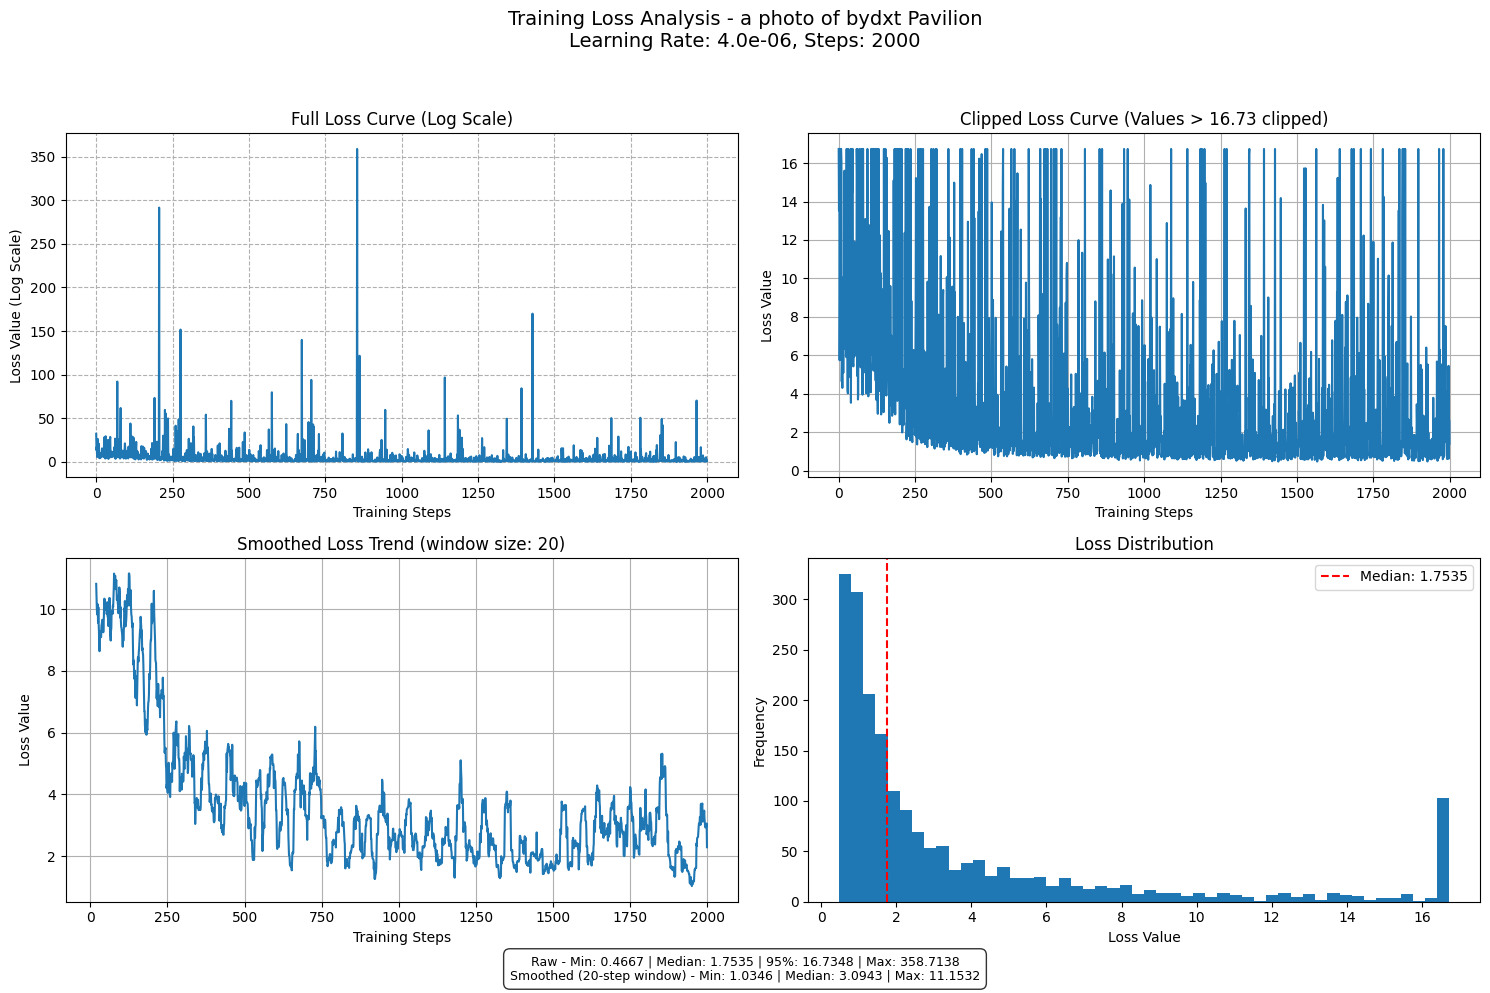

Loss curve analysis saved to: ./dreambooth-sd35/loss_curves/loss_analysis_text_encoder_bydxt_4.0em06_2000steps.png


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os

if len(loss_history) > 0:
    # 分析损失值
    median_loss = np.median(loss_history)
    q75 = np.percentile(loss_history, 75)
    q95 = np.percentile(loss_history, 95)
    max_loss = max(loss_history)
    min_loss = min(loss_history)
    
    # 创建一个包含多个子图的图表
    fig = plt.figure(figsize=(15, 10))
    
    # 原始损失曲线（对数尺度）
    ax1 = fig.add_subplot(221)
    ax1.plot(loss_history)
    ax1.set_title('Full Loss Curve (Log Scale)')
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss Value (Log Scale)')
    ax1.grid(True, which="both", ls="--")
    
    # 裁剪掉95%分位数以上的损失值
    ax2 = fig.add_subplot(222)
    clipped_loss = [min(x, q95) for x in loss_history]
    ax2.plot(clipped_loss)
    ax2.set_title(f'Clipped Loss Curve (Values > {q95:.2f} clipped)')
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Loss Value')
    ax2.grid(True)
    
    # 趋势线 - 使用滚动平均减少噪声
    ax3 = fig.add_subplot(223)
    window = min(20, len(loss_history) // 10)  # 动态窗口大小
    if window > 1:
        smoothed = np.convolve(clipped_loss, np.ones(window)/window, mode='valid')
        ax3.plot(range(window-1, len(clipped_loss)), smoothed)
        ax3.set_title(f'Smoothed Loss Trend (window size: {window})')
    else:
        ax3.plot(clipped_loss)
        ax3.set_title('Loss Trend')
    ax3.grid(True)
    ax3.set_xlabel('Training Steps')
    ax3.set_ylabel('Loss Value')
    
    # 损失分布直方图
    ax4 = fig.add_subplot(224)
    ax4.hist(clipped_loss, bins=50)
    ax4.axvline(median_loss, color='r', linestyle='--', label=f'Median: {median_loss:.4f}')
    ax4.set_title('Loss Distribution')
    ax4.set_xlabel('Loss Value')
    ax4.set_ylabel('Frequency')
    ax4.legend()
    
    # 在图表顶部添加总体信息
    plt.suptitle(f'Training Loss Analysis - {instance_prompt}\nLearning Rate: {learning_rate:.1e}, Steps: {num_train_steps}', 
                 fontsize=14)
    
    # 计算平滑后的损失统计数据
    window = min(20, len(loss_history) // 10)
    if window > 1:
        smoothed = np.convolve(clipped_loss, np.ones(window)/window, mode='valid')
        smoothed_median = np.median(smoothed)
        smoothed_min = np.min(smoothed)
        smoothed_max = np.max(smoothed)
        
        # 添加统计信息（包括原始和平滑后的数据）
        fig.text(0.5, 0.01, 
                f"Raw - Min: {min_loss:.4f} | Median: {median_loss:.4f} | 95%: {q95:.4f} | Max: {max_loss:.4f}\n"
                f"Smoothed ({window}-step window) - Min: {smoothed_min:.4f} | Median: {smoothed_median:.4f} | Max: {smoothed_max:.4f}",
                ha='center', fontsize=9, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    else:
        # 如果没有足够的数据进行平滑，只显示原始统计信息
        fig.text(0.5, 0.01, 
                f"Min: {min_loss:.4f} | Median: {median_loss:.4f} | 75%: {q75:.4f} | 95%: {q95:.4f} | Max: {max_loss:.4f}",
                ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局，为底部文本留出空间
    
    filename = f"loss_analysis_text_encoder_{name_of_your_concept}_{learning_rate:.1e}_{num_train_steps}steps.png"
    filename = filename.replace('+', 'p').replace('-', 'm')
    loss_dir = os.path.join(output_dir, "loss_curves")
    os.makedirs(loss_dir, exist_ok=True)
    save_path_img = os.path.join(loss_dir, filename)
    plt.savefig(save_path_img, dpi=300)
    plt.show()
    
    print(f"Loss curve analysis saved to: {save_path_img}")

In [17]:
import os
from transformers import CLIPTokenizer, T5TokenizerFast
from diffusers import StableDiffusion3Pipeline
import datetime
from peft import PeftModel

# 训练循环结束后，直接保存完整模型
if accelerator.is_main_process:
    
    unwrapped_transformer = accelerator.unwrap_model(transformer)
    unwrapped_text_encoder = accelerator.unwrap_model(text_encoder)
    unwrapped_text_encoder_2 = accelerator.unwrap_model(text_encoder_2)

    tokenizer_2 = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer_2",cache_dir="./models/huggingface")
    tokenizer_3 = T5TokenizerFast.from_pretrained(model_id, subfolder="tokenizer_3",cache_dir="./models/huggingface")

pipeline = StableDiffusion3Pipeline(
        transformer=unwrapped_transformer,
        vae=vae,
        text_encoder=unwrapped_text_encoder,
        text_encoder_2=unwrapped_text_encoder_2,
        text_encoder_3=text_encoder_3,
        tokenizer=tokenizer,
        tokenizer_2=tokenizer_2,        
        tokenizer_3=tokenizer_3, 
        scheduler=flow_scheduler
    ).to("cuda")
print("加载完成")

加载完成


In [19]:
import torch
import gc
# del pipe
gc.collect()
torch.cuda.empty_cache()
print(f"当前分配的GPU内存: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"峰值保留: {torch.cuda.max_memory_reserved() / 1e9:.2f} GB")

当前分配的GPU内存: 25.46 GB
峰值保留: 35.70 GB


In [1]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

from huggingface_hub import notebook_login

notebook_login()

### dreambooth模型加载和推理

In [2]:
import os, torch, gc
from torch import autocast
# Diffusers 与 Transformers
from diffusers import DiffusionPipeline, StableDiffusion3Pipeline, BitsAndBytesConfig
from transformers import CLIPTextModel, CLIPTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3.5-medium",
    torch_dtype=torch.bfloat16,
    cache_dir="./models/huggingface"
).to(device)

pipe.enable_attention_slicing()
print("已启用注意力切片。")

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


已启用注意力切片。


In [3]:
# 加载模型检查点
# 先运行第7单元格之前的代码，运行到参数定义部分
import os, gc
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from transformers import CLIPTextModel, CLIPTokenizer, T5EncoderModel, T5TokenizerFast, BitsAndBytesConfig
from diffusers import StableDiffusion3Pipeline, SD3Transformer2DModel, AutoencoderKL, FlowMatchEulerDiscreteScheduler

# 首先清理GPU内存
gc.collect()
torch.cuda.empty_cache()
print(f"初始GPU内存使用: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

# 设置基本参数
model_id = "stabilityai/stable-diffusion-3.5-medium"
output_dir = "./dreambooth-sd35"  # 检查点保存目录
latest_checkpoint = "text_checkpoint-bydxt_4.0e-06_1200steps"  # 指定检查点名称
device = "cuda" if torch.cuda.is_available() else "cpu"

accelerator = Accelerator(
    gradient_accumulation_steps=1,
    mixed_precision="bf16",   #['no', 'fp8', 'fp16', 'bf16']
)
# 加载transformer、text_encoder组件
transformer = pipe.transformer
text_encoder = pipe.text_encoder
text_encoder_2 = pipe.text_encoder_2

# 加载检查点
checkpoint_path = os.path.join(output_dir, latest_checkpoint)
print(f"加载检查点: {checkpoint_path}")
accelerator.load_state(checkpoint_path)

tokenizer = CLIPTokenizer.from_pretrained(os.path.join(checkpoint_path, "tokenizer"))
tokenizer_2 = CLIPTokenizer.from_pretrained(os.path.join(checkpoint_path, "tokenizer_2"))
tokenizer_3 = T5TokenizerFast.from_pretrained(os.path.join(checkpoint_path, "tokenizer_3"))
print(f"已加载自定义tokenizer，词汇表大小：{len(tokenizer)}/{len(tokenizer_2)}/{len(tokenizer_3)}")

# 获取unwrapped模型以构建pipeline
if accelerator.is_main_process:
    #可以只获取transformer部分
    unwrapped_transformer = accelerator.unwrap_model(transformer)
    unwrapped_text_encoder = accelerator.unwrap_model(text_encoder)
    unwrapped_text_encoder_2 = accelerator.unwrap_model(text_encoder_2)
    print("构建StableDiffusion3Pipeline...")

    pipeline = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3.5-medium",
    torch_dtype=torch.bfloat16,
    transformer=unwrapped_transformer,
    text_encoder=unwrapped_text_encoder,
    text_encoder_2=unwrapped_text_encoder_2,
    tokenizer=tokenizer,     
    tokenizer_2=tokenizer_2,
    tokenizer_3=tokenizer_3,
    cache_dir="./models/cache"
    )
    pipeline.enable_attention_slicing()
    pipeline.to(device)

print("加载完成")

初始GPU内存使用: 16.32 GB
加载检查点: ./dreambooth-sd35/text_checkpoint-bydxt_4.0e-06_1200steps
已加载自定义tokenizer，词汇表大小：49409/49409/32101
构建StableDiffusion3Pipeline...


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

加载完成


In [3]:
# 之前定义过的函数
from PIL import Image
def image_grid(imgs, rows, cols, size=256):
    assert len(imgs) == rows * cols
    resized_imgs = []
    for img in imgs:
        resized_imgs.append(img.resize((size, size), Image.LANCZOS))
    grid = Image.new("RGB", size=(cols * size, rows * size))
    for i, img in enumerate(resized_imgs):
        grid.paste(img, box=(i % cols * size, i // cols * size))
    return grid
    
output_dir = "./dreambooth-sd35"

In [6]:
import os
import torch
import gc

concept = "bydxt"
type_word = "Pavilion"

# 开启同步调试模式
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# 清理内存
gc.collect()
torch.cuda.empty_cache()

# 检查和修复每个文本编码器的嵌入维度
print("检查和修复文本编码器维度")

# 检查CLIP编码器1
encoder_size = pipeline.text_encoder.get_input_embeddings().weight.shape[0]
vocab_size = len(pipeline.tokenizer)
print(f"CLIP-1: 词汇表大小={vocab_size}, 嵌入矩阵大小={encoder_size}")
if vocab_size != encoder_size:
    print(f"  正在调整CLIP-1嵌入大小: {encoder_size} → {vocab_size}")
    pipeline.text_encoder.resize_token_embeddings(vocab_size)

# 检查CLIP编码器2
encoder_size = pipeline.text_encoder_2.get_input_embeddings().weight.shape[0]
vocab_size = len(pipeline.tokenizer_2)
print(f"CLIP-2: 词汇表大小={vocab_size}, 嵌入矩阵大小={encoder_size}")
if vocab_size != encoder_size:
    print(f"  正在调整CLIP-2嵌入大小: {encoder_size} → {vocab_size}")
    pipeline.text_encoder_2.resize_token_embeddings(vocab_size)

# 检查T5编码器 
encoder_size = pipeline.text_encoder_3.shared.weight.shape[0]
vocab_size = len(pipeline.tokenizer_3)
print(f"T5: 词汇表大小={vocab_size}, 嵌入矩阵大小={encoder_size}")

if vocab_size != encoder_size:
    print(f"  正在调整T5嵌入大小: {encoder_size} → {vocab_size}")
    
    # 保存原始嵌入
    old_embeds = pipeline.text_encoder_3.shared.weight.data.clone()
    
    # 调整嵌入大小
    pipeline.text_encoder_3.resize_token_embeddings(vocab_size)
    
    # 恢复原始权重 - 使用安全的方式
    with torch.no_grad():
        # 计算安全的复制范围
        copy_size = min(old_embeds.shape[0], pipeline.text_encoder_3.shared.weight.shape[0])
        pipeline.text_encoder_3.shared.weight[:copy_size, :] = old_embeds[:copy_size, :]
        print(f"  已恢复前 {copy_size} 个嵌入向量")

# 重新初始化自定义概念的嵌入
print("重新初始化自定义概念嵌入")


# 获取各个ID
instance_id = pipeline.tokenizer.convert_tokens_to_ids(concept)
instance_id_2 = pipeline.tokenizer_2.convert_tokens_to_ids(concept)
instance_id_3 = pipeline.tokenizer_3.convert_tokens_to_ids(concept)

type_id = pipeline.tokenizer.convert_tokens_to_ids(type_word)
type_id_2 = pipeline.tokenizer_2.convert_tokens_to_ids(type_word)
type_id_3 = pipeline.tokenizer_3.convert_tokens_to_ids(type_word)

print(f"概念ID: CLIP1={instance_id}, CLIP2={instance_id_2}, T5={instance_id_3}")
print(f"类型ID: CLIP1={type_id}, CLIP2={type_id_2}, T5={type_id_3}")

with torch.no_grad():
    # CLIP-1编码器自定义概念初始化
    if instance_id < pipeline.text_encoder.get_input_embeddings().weight.shape[0]:
        type_embedding = pipeline.text_encoder.get_input_embeddings().weight[type_id].clone()
        noise_scale = 0.1
        noise = torch.randn_like(type_embedding) * noise_scale * type_embedding.std()
        pipeline.text_encoder.get_input_embeddings().weight[instance_id] = type_embedding + noise
        print(f"已重新初始化CLIP-1的'{concept}'嵌入")
    
    # CLIP-2编码器自定义概念初始化
    if instance_id_2 < pipeline.text_encoder_2.get_input_embeddings().weight.shape[0]:
        type_embedding = pipeline.text_encoder_2.get_input_embeddings().weight[type_id_2].clone()
        noise_scale = 0.1
        noise = torch.randn_like(type_embedding) * noise_scale * type_embedding.std()
        pipeline.text_encoder_2.get_input_embeddings().weight[instance_id_2] = type_embedding + noise
        print(f"已重新初始化CLIP-2的'{concept}'嵌入")
    
    # T5编码器自定义概念初始化 - 确保索引在有效范围内
    if instance_id_3 < pipeline.text_encoder_3.shared.weight.shape[0]:
        if type_id_3 < pipeline.text_encoder_3.shared.weight.shape[0]:
            type_embedding = pipeline.text_encoder_3.shared.weight[type_id_3].clone()
            noise_scale = 0.05  # T5编码器使用较小的噪声
            noise = torch.randn_like(type_embedding) * noise_scale * type_embedding.std()
            pipeline.text_encoder_3.shared.weight[instance_id_3] = type_embedding + noise
            print(f"已重新初始化T5的'{concept}'嵌入，使用类型'{type_word}'作为基础")
        else:
            # 类型ID无效，使用平均嵌入
            print(f"警告：T5类型ID {type_id_3} 超出了嵌入矩阵范围 {pipeline.text_encoder_3.shared.weight.shape[0]}")
            # 尝试使用一些通用概念的平均嵌入
            similar_tokens = ["building", "structure", "architecture"]
            similar_ids = [pipeline.tokenizer_3.convert_tokens_to_ids(t) for t in similar_tokens]
            # 确保ID在有效范围内
            valid_ids = [i for i in similar_ids if i < pipeline.text_encoder_3.shared.weight.shape[0]]
            
            if valid_ids:
                avg_embedding = pipeline.text_encoder_3.shared.weight[valid_ids].mean(dim=0)
                pipeline.text_encoder_3.shared.weight[instance_id_3] = avg_embedding
                print(f"已重新初始化T5的'{concept}'嵌入，使用相似词的平均嵌入")
            else:
                print(f"警告：无法为T5找到合适的初始化嵌入，使用随机初始化")
                pipeline.text_encoder_3.shared.weight[instance_id_3] = torch.randn_like(pipeline.text_encoder_3.shared.weight[0]) * 0.02

pipeline.to("cuda");

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


检查和修复文本编码器维度
CLIP-1: 词汇表大小=49409, 嵌入矩阵大小=49408
  正在调整CLIP-1嵌入大小: 49408 → 49409
CLIP-2: 词汇表大小=49409, 嵌入矩阵大小=49408
  正在调整CLIP-2嵌入大小: 49408 → 49409
T5: 词汇表大小=32101, 嵌入矩阵大小=32128
  正在调整T5嵌入大小: 32128 → 32101
  已恢复前 32101 个嵌入向量
重新初始化自定义概念嵌入
概念ID: CLIP1=49408, CLIP2=49408, T5=32100
类型ID: CLIP1=49407, CLIP2=49407, T5=2
已重新初始化CLIP-1的'bydxt'嵌入
已重新初始化CLIP-2的'bydxt'嵌入
已重新初始化T5的'bydxt'嵌入，使用类型'Pavilion'作为基础


  0%|          | 0/50 [00:00<?, ?it/s]

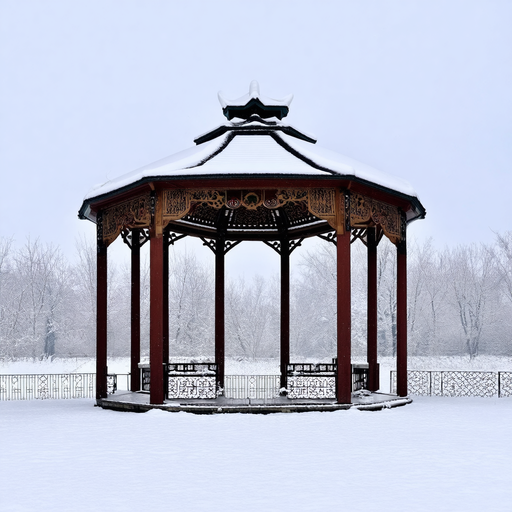

In [7]:
import datetime
from torch.amp import autocast
prompt = "a photo of a bydxt Pavilion in the snow"
# prompt = "a photo of the Tupperware bottle in the snow"
# negative_prompt = "lowres, blurry, bad quality, deformed, ugly"
guidance_scale = 7
num_inference_steps = 50
height = 512
width = 512
generator = torch.Generator(device="cuda").manual_seed(343)#343

num_cols = 1
all_images = []
for _ in range(num_cols):
    with autocast(device_type="cuda", dtype=torch.bfloat16):
        images = pipeline(
            prompt=prompt,
            # negative_prompt=negative_prompt,
            # height=height,
            # width=width,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            generator=generator
        ).images
        all_images.extend(images)

grid = image_grid(all_images, rows=1, cols=num_cols, size=512)
images_dir = os.path.join(output_dir, "text_checkpoint-bydxt_4.0e-06_1200steps")
os.makedirs(images_dir, exist_ok=True)
# grid.save(os.path.join(images_dir, f"Img_{latest_checkpoint}_{guidance_scale}scale_{num_inference_steps}inf_steps_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"))
display(grid)

In [ ]:
import torch
import gc
# 运行垃圾回收
#del pipeline
gc.collect()
# 清空CUDA缓存
torch.cuda.empty_cache()
print(f"当前分配的GPU内存: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"峰值保留: {torch.cuda.max_memory_reserved() / 1e9:.2f} GB")

计算FID

In [ ]:
import datetime, os, torch, time
from torch.amp import autocast
from tqdm.auto import tqdm

# 设置参数
prompt = "a photo of a bydxt Pavilion in the snow"  # 根据您的需要调整提示词
guidance_scale = 5
num_inference_steps = 50
height = 512
width = 512
num_images_total = 100  # 需要生成的图片总数

# 创建FID数据集保存目录
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
fid_dataset_dir = os.path.join(output_dir, f"fid_dataset_{timestamp}")
os.makedirs(fid_dataset_dir, exist_ok=True)

print(f"开始生成FID数据集，总计图片数: {num_images_total}，保存目录: {fid_dataset_dir}")

# 设置基本种子
base_seed = 42
images_generated = 0
start_time = time.time()

# 使用tqdm创建进度条
progress_bar = tqdm(total=num_images_total, desc="生成FID数据集")

# 批量生成图片
try:
    while images_generated < num_images_total:
        # 每次生成一张图片，使用不同种子
        seed = base_seed + images_generated
        generator = torch.Generator(device="cuda").manual_seed(seed)
        
        with autocast(device_type="cuda", dtype=torch.bfloat16):
            image = pipe(
                prompt=prompt,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                height=height,
                width=width,
                generator=generator,
            ).images[0]
        
        # 保存图片，使用序号命名
        img_filename = f"fid_image_{images_generated:04d}.png"
        img_path = os.path.join(fid_dataset_dir, img_filename)
        image.save(img_path)
        
        # 更新计数和进度条
        images_generated += 1
        progress_bar.update(1)
        
        # 显示进度和预计剩余时间
        elapsed = time.time() - start_time
        images_per_sec = images_generated / elapsed
        remaining_time = (num_images_total - images_generated) / images_per_sec if images_per_sec > 0 else 0
        
        progress_bar.set_postfix({
            "速度": f"{images_per_sec:.2f}张/秒",
            "剩余时间": f"{remaining_time/60:.1f}分钟"
        })
        
        # 每10张图片清理一次CUDA缓存，防止内存泄漏
        if images_generated % 10 == 0:
            torch.cuda.empty_cache()
    
except KeyboardInterrupt:
    print(f"\n生成过程被中断。已生成 {images_generated} 张图片。")
except Exception as e:
    print(f"\n生成过程出错: {str(e)}。已生成 {images_generated} 张图片。")
finally:
    progress_bar.close()
    
    # 输出完成信息
    total_time = time.time() - start_time
    if images_generated > 0:
        avg_time_per_image = total_time / images_generated
        print(f"FID数据集生成完成! 共 {images_generated} 张图片")
        print(f"总用时: {total_time:.1f}秒 (平均 {avg_time_per_image:.2f}秒/张)")
    else:
        print(f"未能生成任何图片。总运行时间: {total_time:.1f}秒")
    print(f"保存路径: {fid_dataset_dir}")
    
    # 保存数据集信息
    with open(os.path.join(fid_dataset_dir, "dataset_info.txt"), "w") as f:
        f.write(f"生成日期: {datetime.datetime.now()}\n")
        f.write(f"提示词: {prompt}\n")
        f.write(f"参数: guidance_scale={guidance_scale}, steps={num_inference_steps}\n")
        f.write(f"图片数量: {images_generated}\n")
        f.write(f"总生成时间: {total_time:.1f}秒\n")

In [7]:
import os
# 指向国内镜像（可选）
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

from huggingface_hub import notebook_login
notebook_login()  # 在 notebook 弹窗中填入你的 HF 访问令牌


In [16]:
from datasets import load_dataset
import os
from PIL import Image

# 1. 本地保存目录
output_dir = "./cifar10-train"
os.makedirs(output_dir, exist_ok=True)

# 2. 下载并加载 CIFAR-10 训练集
ds = load_dataset("cifar10", split="train")

# 3. 遍历并保存每张图像
for idx, example in enumerate(ds):
    # example["img"] 是 PIL Image 对象也可能是 numpy array
    img = example["img"]
    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)
    # CIFAR-10 原始尺寸 32×32，无需调整
    fname = f"{idx:05d}.png"
    img.save(os.path.join(output_dir, fname))

print(f"共保存 {len(ds)} 张训练图像到 {output_dir}")


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

共保存 50000 张训练图像到 ./cifar10-train


In [19]:
import os
import torch
from cleanfid import fid
os.environ['CLEANFID_CACHE'] = "./fid_cache"
output_dir = "./dreambooth-sd35"
# 创建目录路径
fid_dataset_dir = os.path.join(output_dir, "fid_dataset_20250530_1804")  # 您生成的图像路径
reference_dataset = "cifar10-train"   # 使用预处理好的ImageNet验证集

# 计算FID
fid_score = fid.compute_fid(
    fid_dataset_dir,  # 生成图像路径 
    reference_dataset,  # 参考数据集
    mode="clean",  # 使用官方实现的标准化预处理
    device="cuda" if torch.cuda.is_available() else "cpu",
    batch_size=32,
    verbose=True
)

print(f"FID分数: {fid_score:.4f}")

compute FID between two folders
Found 50 images in the folder ./dreambooth-sd35/fid_dataset_20250530_1804


FID fid_dataset_20250530_1804 : 100%|██████████| 2/2 [00:08<00:00,  4.49s/it]


Found 50000 images in the folder cifar10-train


FID cifar10-train : 100%|██████████| 1563/1563 [00:55<00:00, 27.97it/s]


FID分数: 358.1006


In [21]:
import os
from datasets import load_dataset
from PIL import Image
import torch
from cleanfid import fid

gen_dir = "./dreambooth-sd35/fid_dataset_20250530_1824"  # 你已经有的生成图
ref_dir = "./datasets/tju-pavilion-ref"                         # 准备存放参考图

os.makedirs(ref_dir, exist_ok=True)

dataset_id = "zjake/Memorial-Pavilion-of-TJU"
ds = load_dataset(dataset_id, split="train", cache_dir="./datasets")

for idx, example in enumerate(ds):
    img = example["image"]
    # 如果不是 PIL.Image，把它转成
    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)
    img = img.convert("RGB")
    # 保存成 PNG 或 JPEG
    fname = f"{idx:05d}.png"
    img.save(os.path.join(ref_dir, fname))

print(f"共导出 {len(ds)} 张参考图到 {ref_dir}")


os.environ['CLEANFID_CACHE'] = "./fid_cache"
fid_score = fid.compute_fid(
    gen_dir,            # 你的生成图文件夹
    ref_dir,            # 你刚导出的参考图文件夹
    mode="clean",
    device="cuda" if torch.cuda.is_available() else "cpu",
    batch_size=32,
    verbose=True
)
print(f"FID 分数: {fid_score:.4f}")

共导出 10 张参考图到 ./datasets/tju-pavilion-ref
compute FID between two folders
Found 100 images in the folder ./dreambooth-sd35/fid_dataset_20250530_1824


FID fid_dataset_20250530_1824 : 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Found 10 images in the folder ./datasets/tju-pavilion-ref


FID tju-pavilion-ref : 100%|██████████| 1/1 [00:08<00:00,  8.94s/it]


FID 分数: 303.4325


In [ ]:
raise error

# LoRA 风格迁移

In [ ]:
import os, math, torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator
from accelerate.utils import set_seed
from diffusers import (
    StableDiffusion3Pipeline,
    BitsAndBytesConfig,
    AutoencoderKL,
    SD3Transformer2DModel,
    FlowMatchEulerDiscreteScheduler
)
from diffusers.optimization import get_scheduler as get_lr_scheduler
from diffusers.training_utils import (
    compute_density_for_timestep_sampling,
    compute_loss_weighting_for_sd3
)
from peft import LoraConfig, get_peft_model, get_peft_model_state_dict, PeftModel
from transformers import (
    CLIPTokenizer, CLIPTextModelWithProjection,
    T5TokenizerFast, T5EncoderModel
)
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm


In [ ]:
config = {
    "model_id": "stabilityai/stable-diffusion-3.5-medium",
    "style_dataset_id": "huggan/wikiart",
    "output_dir": "./sd3-lora-style",
    "seed": 42,
    "resolution": 512,
    "train_batch_size": 2,#保持2不动
    "gradient_accumulation": 1,
    "learning_rate": 1e-5,
    "num_train_epochs": 1,
    "num_train_steps": 250,
    "lr_scheduler_type": "linear",
    "lr_warmup_steps": 100,
    "lora_rank": 16,
    "lora_alpha": 32,
    "max_grad_norm": 1.0,
    "mixed_precision": "bf16", #['no', 'fp8', 'fp16', 'bf16']
    "weighting_scheme": "logit_normal"
}

In [ ]:
from PIL import Image
def image_grid(imgs, rows, cols, size=256):
    assert len(imgs) == rows * cols
    resized_imgs = []
    for img in imgs:
        resized_imgs.append(img.resize((size, size), Image.LANCZOS))
    grid = Image.new("RGB", size=(cols * size, rows * size))
    for i, img in enumerate(resized_imgs):
        grid.paste(img, box=(i % cols * size, i // cols * size))
    return grid

In [ ]:
# 加载模型检查点
import os, gc
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from transformers import CLIPTextModel, CLIPTokenizer, T5EncoderModel, T5TokenizerFast, BitsAndBytesConfig
from diffusers import StableDiffusion3Pipeline, SD3Transformer2DModel, AutoencoderKL, FlowMatchEulerDiscreteScheduler

# 首先清理GPU内存
gc.collect()
torch.cuda.empty_cache()
print(f"初始GPU内存使用: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

# 设置基本参数
model_id = "stabilityai/stable-diffusion-3.5-medium"
dreambooth_dir = "./dreambooth-sd35"  # 检查点保存目录
latest_checkpoint = "checkpoint-tbhwbx-2000"  # 指定检查点名称
device = "cuda" if torch.cuda.is_available() else "cpu"

accelerator = Accelerator(
    mixed_precision=config["mixed_precision"],
    gradient_accumulation_steps=config["gradient_accumulation"]
)
transformer = SD3Transformer2DModel.from_pretrained(
    config["model_id"],
    subfolder="transformer",
    torch_dtype=torch.bfloat16
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_enable_fp32_cpu_offload=True
)
device_map = {
    # 只将必要的部分放在GPU上
    "shared": "cpu",
    "encoder.embed_tokens": "cpu",
    "encoder.block": "cpu",
    "encoder.final_layer_norm": "cpu"
}
text_encoder_3 = T5EncoderModel.from_pretrained(
    config["model_id"],
    subfolder="text_encoder_3",
    quantization_config=bnb_config,  
    device_map=device_map,
    torch_dtype=torch.bfloat16
)

# 加载检查点
checkpoint_path = os.path.join(dreambooth_dir, latest_checkpoint)
print(f"加载检查点: {checkpoint_path}")
accelerator.load_state(checkpoint_path)

# 获取unwrapped模型以构建pipeline
if accelerator.is_main_process:
    #可以只获取transformer部分
    unwrapped_transformer = accelerator.unwrap_model(transformer)
    print("构建StableDiffusion3Pipeline...")

    pipeline = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3.5-medium",
    torch_dtype=torch.bfloat16,
    transformer=unwrapped_transformer,
    text_encoder_3=text_encoder_3
    )
    pipeline.enable_model_cpu_offload()
    pipeline.enable_attention_slicing()
    try:
        pipeline.enable_xformers_memory_efficient_attention()
        print("已启用xFormers高效注意力")
    except:
        print("无法启用xFormers")
    pipeline.to(device)


In [ ]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
print(f"当前分配的GPU内存: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"峰值保留: {torch.cuda.max_memory_reserved() / 1e9:.2f} GB")

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from torchvision import transforms

style_name = "Realism"
# 可选风格 style_name
# ['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 
# 'Art_Nouveau', 'Baroque', 'Color_Field_Painting', 'Contemporary_Realism',
# 'Cubism', 'Early_Renaissance', 'Expressionism', 'Fauvism', 'High_Renaissance',
# 'Impressionism', 'Mannerism_Late_Renaissance', 'Minimalism', 'Naive_Art_Primitivism',
# 'New_Realism', 'Northern_Renaissance', 'Pointillism', 'Pop_Art', 'Post_Impressionism',
# 'Realism', 'Rococo', 'Romanticism', 'Symbolism', 'Synthetic_Cubism', 'Ukiyo_e']

class StyleDataset(Dataset):
    def __init__(
        self,
        hf_id: str,
        split: str = "train",
        resolution: int = 512,
        limit: int = 50,
        style_name: str = "Impressionism",
    ):
        ds = load_dataset( # 加载数据集（流式模式）
            hf_id,
            split=split,
            streaming=True
        )
        style_feature = ds.features["style"]
        style_names = style_feature.names
        try:
            target_idx = style_names.index(style_name)
        except ValueError:
            raise ValueError(f"Style '{style_name}' not in available styles: {style_names}")

        self.images = []
        for ex in ds:
            if ex["style"] == target_idx:
                self.images.append(ex["image"])
                if len(self.images) >= limit:
                    break
        if not self.images:
            raise ValueError(f"No images found for style '{style_name}'")

        self.transform = transforms.Compose([
            transforms.Resize(resolution),
            transforms.CenterCrop(resolution),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]
            ),
        ])
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if not isinstance(img, Image.Image):
            img = Image.open(img).convert("RGB")
        return {"pixel_values": self.transform(img)}

style_ds = StyleDataset(
    hf_id="huggan/wikiart",
    split="train",
    resolution=512,
    limit=50,
    style_name=style_name,
)

train_loader = DataLoader(
    style_ds,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

In [ ]:
from IPython.display import display

# 收集前10张原始PIL格式图像
pil_images = []
for i in range(min(10, len(style_ds))):
    img = style_ds.images[i]
    if not isinstance(img, Image.Image):
        img = Image.open(img).convert("RGB")
    pil_images.append(img)


# 创建并显示图像网格
grid = image_grid(pil_images, rows=1, cols=10, size=256)
display(grid)

In [ ]:
lora_config = LoraConfig(
    r=config["lora_rank"],
    lora_alpha=config["lora_alpha"],
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0,
    bias="none",
)
transformer = get_peft_model(transformer, lora_config)
peft_model: PeftModel = transformer
pipeline.transformer = transformer

In [ ]:
import bitsandbytes as bnb
set_seed(config["seed"])
# accelerator = Accelerator(
#     mixed_precision=config["mixed_precision"],
#     gradient_accumulation_steps=config["gradient_accumulation_steps"]
# )
# 优化 LoRA 参数
optimizer = bnb.optim.Adam8bit(
    transformer.parameters(), lr=config["learning_rate"]
)

# 学习率调度器
lr_scheduler = get_lr_scheduler(
    config["lr_scheduler_type"], optimizer,
    num_warmup_steps=config["lr_warmup_steps"],
    num_training_steps=config["num_train_steps"]
)

# Accelerator 包装

vae = pipeline.vae
text_encoder = pipeline.text_encoder
text_encoder_2 = pipeline.text_encoder_2
scheduler = pipeline.scheduler

vae.to(accelerator.device, dtype=torch.bfloat16)
text_encoder.to(accelerator.device)
text_encoder_2.to(accelerator.device)

transformer, text_encoder, text_encoder_2, optimizer, train_loader, lr_scheduler = accelerator.prepare(
    transformer,  text_encoder, text_encoder_2, optimizer, train_loader, lr_scheduler
)

### lora训练

In [ ]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from diffusers.training_utils import (
    compute_density_for_timestep_sampling,
    compute_loss_weighting_for_sd3
)

# 训练前初始化

loss_history = []
global_step = 0
transformer.train()
progress_bar = tqdm(total=config["num_train_steps"], desc="LoRA 风格迁移训练", 
                    disable=not accelerator.is_local_main_process)

# 预计算VAE编码
print("预计算VAE编码...")
latents_cache = []
vae.to(accelerator.device)
for batch in tqdm(train_loader, desc="缓存VAE编码"):
    with torch.no_grad():
        pixel_values = batch["pixel_values"].to(accelerator.device,dtype=torch.bfloat16)
        latent = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor
        latents_cache.append(latent.cpu())  # 存储在CPU中节省GPU内存

# 构建新数据集
from torch.utils.data import TensorDataset, DataLoader
latents_dataset = TensorDataset(torch.cat(latents_cache))
cached_dataloader = DataLoader(
    latents_dataset, 
    batch_size=config["train_batch_size"], 
    shuffle=True
)

# 预计算空提示词嵌入
print("预计算文本嵌入...")
prompts = [""] * config["train_batch_size"]
with torch.no_grad():
    prompt_embeds, _, pooled_prompt_embeds, _ = pipeline.encode_prompt(
        prompts, prompts, prompts,
        do_classifier_free_guidance=False,
        num_images_per_prompt=1
    )

for param in vae.parameters(): param.requires_grad = False

num_batches = len(cached_dataloader)
num_epochs = (config["num_train_steps"]*config["gradient_accumulation"]) // num_batches +1
print(f"将训练 {num_epochs} 个epoch，总计 {config["num_train_steps"]} 步")

for epoch in range(num_epochs):
    for latents in cached_dataloader:
        latents = latents[0].to(accelerator.device)
        bsz = latents.shape[0]

        # 采样 & 预条件化
        noise = torch.randn_like(latents)
        u = compute_density_for_timestep_sampling(
                weighting_scheme="logit_normal",
                batch_size=bsz,
                logit_mean=0.0,
                logit_std=1.0,
                mode_scale=None
            ).to(latents.device)
        idx = (u * (scheduler.config.num_train_timesteps - 1)).long().to(latents.device)

        timesteps = scheduler.timesteps.to(latents.device)[idx]
        
        sigmas = scheduler.sigmas.to(latents.device)[idx].view(bsz, *([1]*(latents.ndim-1)))
        noisy_latents = (1 - sigmas) * latents + sigmas * noise

        # 模型预测
        model_pred_uncond = transformer(
            hidden_states=noisy_latents,
            timestep=timesteps,
            encoder_hidden_states=prompt_embeds,
            pooled_projections=pooled_prompt_embeds,
            return_dict=False
        )[0]

        # 预条件化 & 正确的目标向量
        model_pred = model_pred_uncond * (-sigmas) + noisy_latents
        target = noise - latents

        # 加权损失
        weighting = compute_loss_weighting_for_sd3(config["weighting_scheme"], sigmas)
        loss_per_pixel = weighting * (model_pred - target).pow(2)
        loss = loss_per_pixel.view(bsz, -1).mean(dim=1).mean()

        # 反向 & 优化
        accelerator.backward(loss)
        accelerator.clip_grad_norm_(transformer.parameters(), config["max_grad_norm"])
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        # 获取当前损失值
        current_loss = loss.detach().item()

        if global_step > 0 and global_step % 1200 == 0 and accelerator.is_main_process:
            unwrapped_transformer = accelerator.unwrap_model(transformer)
            lora_save_path = os.path.join(config["output_dir"], f"lora_checkpoint_{style_name}_{global_step}steps")
            os.makedirs(lora_save_path, exist_ok=True)
            peft_model.save_pretrained(lora_save_path)
            print(f"保存LoRA权重到 {lora_save_path}")
                    
        if accelerator.sync_gradients:
            global_step += 1
            if accelerator.is_main_process:
                loss_history.append(current_loss)
            progress_bar.update(1)
            lr = lr_scheduler.get_last_lr()[0]
            progress_bar.set_postfix({
                "loss": f"{current_loss:.4f}", 
                "lr": f"{lr:.7f}", 
                "epoch": f"{epoch+1}/{num_epochs}"
            })

        if global_step >= config["num_train_steps"]:
            break
progress_bar.close()
# 保存最终检查点与LoRA权重
transformer = accelerator.unwrap_model(transformer)

# 保存LoRA权重
lora_save_path = os.path.join(config["output_dir"], f"lora_checkpoint_{style_name}_{config['learning_rate']:.1e}_{config["num_train_steps"]}steps")
os.makedirs(lora_save_path, exist_ok=True)
peft_model.save_pretrained(lora_save_path)


if len(loss_history) > 0 and accelerator.is_main_process:
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.title(f'LoRA Style Transfer Training Loss\nLearning Rate: {config["learning_rate"]:.1e}')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss Value')
    plt.grid(True)
    
    plt.text(0.98, 0.02, f"learning rate: {config['learning_rate']:.1e}", 
             ha='right', va='bottom', transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

    filename = f"lora_style_loss_{style_name}_{config['learning_rate']:.1e}_{config["num_train_steps"]}steps.png"
    filename = filename.replace('+', 'p').replace('-', 'm')
    
    loss_dir = os.path.join(config["output_dir"], "loss_curves")
    os.makedirs(loss_dir, exist_ok=True)
    save_path_img = os.path.join(loss_dir, filename)
    plt.savefig(save_path_img, dpi=300)
    plt.show()
    
    print(f"损失曲线已保存至: {save_path_img}")

print(f"LoRA 风格迁移完成，权重保存在 {lora_save_path}")

In [ ]:
from datetime import datetime

transformer = accelerator.unwrap_model(transformer)
# transformer_lora_state = get_peft_model_state_dict(transformer)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
formatted_lr = f"{config['learning_rate']:.1e}"
lora_save_path = os.path.join(
    config["output_dir"], 
    f"lora_weights_{style_name}_{formatted_lr}_{config['num_train_steps']}steps_{timestamp}"
)
os.makedirs(lora_save_path, exist_ok=True)
peft_model.save_pretrained(lora_save_path)
# pipeline.save_lora_weights(
#     save_directory=lora_save_path,
#     transformer_lora_layers=transformer_lora_state,
# )

print(f"LoRA 风格迁移完成，权重保存在: {lora_save_path}")

In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()
print(f"初始GPU内存使用: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

### lora加载和推理

In [ ]:
#先运行前三格
##可以加载dreambooth微调后的模型
print("正在加载基础模型...")
pipeline = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3.5-medium",
    torch_dtype=torch.bfloat16
)
pipeline.to("cuda")

pipeline.enable_model_cpu_offload()
pipeline.enable_attention_slicing()
try:
    pipeline.enable_xformers_memory_efficient_attention()
    print("已启用xFormers高效注意力")
except:
    print("无法启用xFormers")

In [ ]:
import os, re
import torch
import gc
from diffusers import StableDiffusion3Pipeline
from PIL import Image
from datetime import datetime
from peft import PeftModel

gc.collect()
torch.cuda.empty_cache()
print(f"初始GPU内存使用: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

style_name = "Realism"
lora_dir = "./sd3-lora-style" #config["output_dir"]

def extract_timestamp(dirname):
    match = re.search(r'(\d{8}_\d{6})', dirname)
    if match:
        return datetime.strptime(match.group(1), '%Y%m%d_%H%M%S')
    return datetime(1970, 1, 1)

lora_dirs =[d for d in os.listdir(lora_dir) if d.startswith(f"lora_weights_{style_name}")]
latest_wehights = sorted(lora_dirs, key=extract_timestamp)[-1]
# latest_wehights = "lora_checkpoint_Realism_5.0e-05_1000steps"

lora_path = os.path.join(lora_dir, latest_wehights)

print(f"正在加载LoRA权重: {lora_path}")
peft_transformer: PeftModel = PeftModel.from_pretrained(pipeline.transformer, lora_path)
merged_transformer = peft_transformer.merge_and_unload()
pipeline.transformer = merged_transformer

# pipeline.load_lora_weights(lora_path, adapter_name=style_name)
# pipeline.fuse_lora()

# LoRA权重比例（1.0为完全应用）
# lora_scale = 1  # 0-1
# pipeline.set_adapters([style_name], adapter_weights=[lora_scale])

#刚训练完可跳过加载部分运行此部分代码
lora_dir = "./sd3-lora-style"
merged_transformer=transformer.merge_and_unload()
pipeline.transformer = merged_transformer
pipeline.to("cuda")

In [ ]:
import datetime
from torch.amp import autocast
prompt = "a photo of the bottle on a wooden table"
# negative_prompt = "lowres, blurry, bad quality, deformed, ugly"
guidance_scale = 7
# 调整指导来控制生成的图像遵循提示的紧密程度。
# 指导值 4.5-5 ,推理步数在30-40
num_inference_steps = 50
height = 512
width = 512
generator = torch.Generator(device="cuda").manual_seed(3434554)

num_cols = 1
all_images = []
for _ in range(num_cols):
    with autocast(device_type="cuda", dtype=torch.bfloat16):
        images = pipeline(
            prompt=prompt,
            # negative_prompt=negative_prompt,
            # height=height,
            # width=width,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            generator=generator,
        ).images
        all_images.extend(images)

grid = image_grid(all_images, rows=1, cols=num_cols, size=512)
images_dir = os.path.join(lora_dir, "lora_generated_images")
os.makedirs(images_dir, exist_ok=True)
grid.save(os.path.join(images_dir, f"lora_results_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"))
display(grid)

# 采样改进

In [ ]:
import torch
from diffusers import StableDiffusion3Pipeline, FlowMatchEulerDiscreteScheduler
from diffusers.models.attention_processor import AttnProcessor

class DiffInjectionProcessor(AttnProcessor):
    
    def __init__(self, base_processor: AttnProcessor):
        self.base = base_processor
        self.proj = torch.nn.Conv2d(
            in_channels=base_processor.hidden_size,
            out_channels=base_processor.hidden_size,
            kernel_size=1,
        )
        self.diff_map = None

    def __call__(self, attn, hidden_states, query, key, value, **kwargs):
        out = self.base(attn, hidden_states, query, key, value, **kwargs)
        if self.diff_map is not None:
            ctx = self.proj(self.diff_map)
            out = out + ctx
        return out

    def set_diff_map(self, diff_map):
        self.diff_map = diff_map
    
    def clear_diff_map(self):
        self.diff_map = None


def create_diff_injection_pipeline(base_pipe):
    pipe = base_pipe
    processors = []

    for module in pipe.transformer.modules():
        if hasattr(module, "processor") and isinstance(module.processor, AttnProcessor):
            processor = DiffInjectionProcessor(module.processor)
            module.set_processor(processor)
            processors.append(processor)

    return pipe, processors


@torch.no_grad()
def generate_with_diff_injection(pipe, processors, prompt, num_steps=30, guidance_scale=7.5, height=512, width=512):
  
    device = pipe.device

    prompt_embeds, _, pooled_prompt_embeds, _ = pipe.encode_prompt(
        prompt, prompt, prompt,
        device=device,
        num_images_per_prompt=1,
        do_classifier_free_guidance=True,
    )
  
    pipe.scheduler.set_timesteps(num_steps)
    in_channels = pipe.transformer.config.in_channels
    vae_scale_factor = 8  # SD3 的VAE下采样因子是8

    initial_noise_level = pipe.scheduler.sigmas[0] if len(pipe.scheduler.sigmas) > 0 else 1.0
    
    latents = torch.randn(
        (1, in_channels, height // vae_scale_factor, width // vae_scale_factor),
        device=device,
        dtype=torch.bfloat16,
    ) * initial_noise_level
 
    history = []
    
    # 设置进度条（参考官方写法）
    import sys
    is_notebook = 'ipykernel' in sys.modules
    
    from tqdm.auto import tqdm
    from tqdm.notebook import tqdm as tqdm_notebook
    
    if is_notebook:
        progress_bar = tqdm_notebook(pipe.scheduler.timesteps)
    else:
        progress_bar = tqdm(pipe.scheduler.timesteps)
    
    for t in progress_bar:
        history.append(latents.clone())

        if len(history) >= 3:
            diff_map = history[-3] - history[-2]
            for processor in processors:
                processor.set_diff_map(diff_map)
        else:
            for processor in processors:
                processor.set_diff_map(torch.zeros_like(latents))

        latent_input = torch.cat([latents] * 2)
        batch_size = latent_input.shape[0]

        timesteps = torch.full((batch_size,), t, device=device, dtype=torch.long)

        if hasattr(pipe.scheduler, "scale_model_input"):
            latent_input = pipe.scheduler.scale_model_input(latent_input, timesteps)

        out = pipe.transformer(
            hidden_states=latent_input,
            timestep=timesteps,
            encoder_hidden_states=prompt_embeds,
            pooled_projections=pooled_prompt_embeds,
        )
        noise_pred = out.sample

        uncond_pred, text_pred = noise_pred.chunk(2)
        noise_pred = uncond_pred + guidance_scale * (text_pred - uncond_pred)

        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

        for processor in processors:
            processor.clear_diff_map()

    latents = latents / pipe.vae.config.scaling_factor
    imgs = pipe.vae.decode(latents).sample
    imgs = (imgs / 2 + 0.5).clamp(0, 1)
    imgs = imgs.cpu().permute(0, 2, 3, 1).float().numpy()

    return pipe.numpy_to_pil(imgs)

In [ ]:
from PIL import Image
def image_grid(imgs, rows, cols, size=256):
    assert len(imgs) == rows * cols
    resized_imgs = []
    for img in imgs:
        resized_imgs.append(img.resize((size, size), Image.LANCZOS))
    grid = Image.new("RGB", size=(cols * size, rows * size))
    for i, img in enumerate(resized_imgs):
        grid.paste(img, box=(i % cols * size, i // cols * size))
    return grid

In [ ]:
# 加载模型
model_id = "stabilityai/stable-diffusion-3.5-medium"
pipe = StableDiffusion3Pipeline.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
)
pipe.enable_attention_slicing()
try:
    pipe.enable_xformers_memory_efficient_attention()
    print("已启用xFormers高效注意力")
except:
    print("无法启用xFormers")

pipe.to("cuda")

### 推理

In [ ]:
import datetime,os
from torch.amp import autocast
prompt = "a photo of the bottle on a wooden table"
# prompt = "A futuristic cityscape at dusk"
# negative_prompt = "lowres, blurry, bad quality, deformed, ugly"
guidance_scale = 7
num_inference_steps = 50
height = 512
width = 512
generator = torch.Generator(device="cuda").manual_seed(3434554)
diff_pipe, processors = create_diff_injection_pipeline(pipe)

num_cols = 3
all_images = []
for _ in range(num_cols):
    with autocast(device_type="cuda", dtype=torch.bfloat16):
        images = generate_with_diff_injection(
            diff_pipe,
            processors,
            prompt=prompt, 
            num_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            height=height,
            width=width
        )
        all_images.extend(images)

grid = image_grid(all_images, rows=1, cols=num_cols, size=512)
images_dir = os.path.join("./ImprovedSampling", "diff_injection_images")
os.makedirs(images_dir, exist_ok=True)
grid.save(os.path.join(images_dir, f"diff_injection_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"))
display(grid)

In [ ]:
#不使用改进的推理
import datetime
from torch.amp import autocast
prompt = "a photo of the bottle on a wooden table"#tbhwbx #in the style of Realism
# prompt = "A futuristic cityscape at dusk"
# negative_prompt = "lowres, blurry, bad quality, deformed, ugly"
guidance_scale = 7
num_inference_steps = 50
height = 512
width = 512
generator = torch.Generator(device="cuda").manual_seed(3434554)

num_cols = 1
all_images = []
for _ in range(num_cols):
    with autocast(device_type="cuda", dtype=torch.bfloat16):
        images = pipe(
            prompt=prompt,
            # negative_prompt=negative_prompt,
            # height=height,
            # width=width,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            generator=generator,
        ).images
        all_images.extend(images)

grid = image_grid(all_images, rows=1, cols=num_cols, size=512)
display(grid)